# Hospital Readmission Prediction



### Objective
#### To build a predictive model that can identify patients who are at high risk of hospital readmission within 30 days after their initial discharge.

1. Import Libraries

In [394]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, QuantileTransformer, PowerTransformer, RobustScaler, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
import scipy.stats as stats

In [395]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

2. Read Data

In [396]:
df = pd.read_csv("hospital_readmissions.csv")

3. Data Cleaning And Exploratory Data Analysis

In [397]:
df.head(10)

,Patient_ID,Age,Gender,Admission_Type,Diagnosis,Num_Lab_Procedures,Num_Medications,Num_Outpatient_Visits,Num_Inpatient_Visits,Num_Emergency_Visits,Num_Diagnoses,A1C_Result,Readmitted
0,1,69,Other,Emergency,Heart Disease,33,2,4,1,1,5,NaN,Yes
1,2,32,Female,Urgent,Diabetes,81,10,4,4,1,6,NaN,No
2,3,78,Female,Urgent,Heart Disease,75,29,4,0,3,5,Normal,No
3,4,38,Male,Elective,Diabetes,77,11,2,3,4,9,NaN,Yes
4,5,41,Female,Urgent,Diabetes,50,25,3,4,1,3,NaN,Yes
5,6,20,Male,Elective,Injury,11,20,3,4,1,3,NaN,No
6,7,39,Female,Elective,Heart Disease,95,16,2,4,3,7,NaN,Yes
7,8,70,Female,Elective,Heart Disease,28,19,4,0,3,7,Normal,Yes
8,9,19,Male,Urgent,Infection,70,23,1,2,4,6,Normal,No
9,10,47,Male,Emergency,Injury,41,24,4,0,0,3,Abnormal,No


In [398]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Patient_ID             1000 non-null   int64 
 1   Age                    1000 non-null   int64 
 2   Gender                 1000 non-null   object
 3   Admission_Type         1000 non-null   object
 4   Diagnosis              1000 non-null   object
 5   Num_Lab_Procedures     1000 non-null   int64 
 6   Num_Medications        1000 non-null   int64 
 7   Num_Outpatient_Visits  1000 non-null   int64 
 8   Num_Inpatient_Visits   1000 non-null   int64 
 9   Num_Emergency_Visits   1000 non-null   int64 
 10  Num_Diagnoses          1000 non-null   int64 
 11  A1C_Result             566 non-null    object
 12  Readmitted             1000 non-null   object
dtypes: int64(8), object(5)
memory usage: 101.7+ KB


* We have 5 categorical and 8 Non-Categorical Variables.
* Column 'A1C_Result' is the only one having missing values.

In [399]:
df.shape

(1000, 13)

In [400]:
df.describe()

,Patient_ID,Age,Num_Lab_Procedures,Num_Medications,Num_Outpatient_Visits,Num_Inpatient_Visits,Num_Emergency_Visits,Num_Diagnoses
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,51.665000,50.836000,15.661000,2.016000,2.019000,1.956000,5.011000
std,288.819436,21.989459,28.075137,8.230177,1.399894,1.416561,1.409983,2.664203
min,1.000000,18.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,250.750000,34.000000,27.000000,9.000000,1.000000,1.000000,1.000000,3.000000
50%,500.500000,50.500000,52.000000,16.000000,2.000000,2.000000,2.000000,5.000000
75%,750.250000,69.000000,75.000000,23.000000,3.000000,3.000000,3.000000,7.000000
max,1000.000000,150.000000,99.000000,35.000000,4.000000,4.000000,4.000000,9.000000


* Clearly there is an outlier in age column - maximum age is 150

In [401]:
df.duplicated().sum()

0

* No rows are duplicated, ie. all rows are unique

In [402]:
df.isnull().sum()

Patient_ID                 0
Age                        0
Gender                     0
Admission_Type             0
Diagnosis                  0
Num_Lab_Procedures         0
Num_Medications            0
Num_Outpatient_Visits      0
Num_Inpatient_Visits       0
Num_Emergency_Visits       0
Num_Diagnoses              0
A1C_Result               434
Readmitted                 0
dtype: int64

* Almost 50% values in the 'A1C_Result' column is null data.
* So we will drop the 'A1C_Result' column if it is not an crucial impacting factor for hospital readmission.

In [403]:
len(df["Patient_ID"].unique())

1000

* All records are of unique patients

Column 'Patient_ID' don't provide meaningful information for the task at hand, so we can drop it.

In [404]:
df.drop(columns=["Patient_ID"], inplace=True)

##### Outlier Detection Using Box Plots

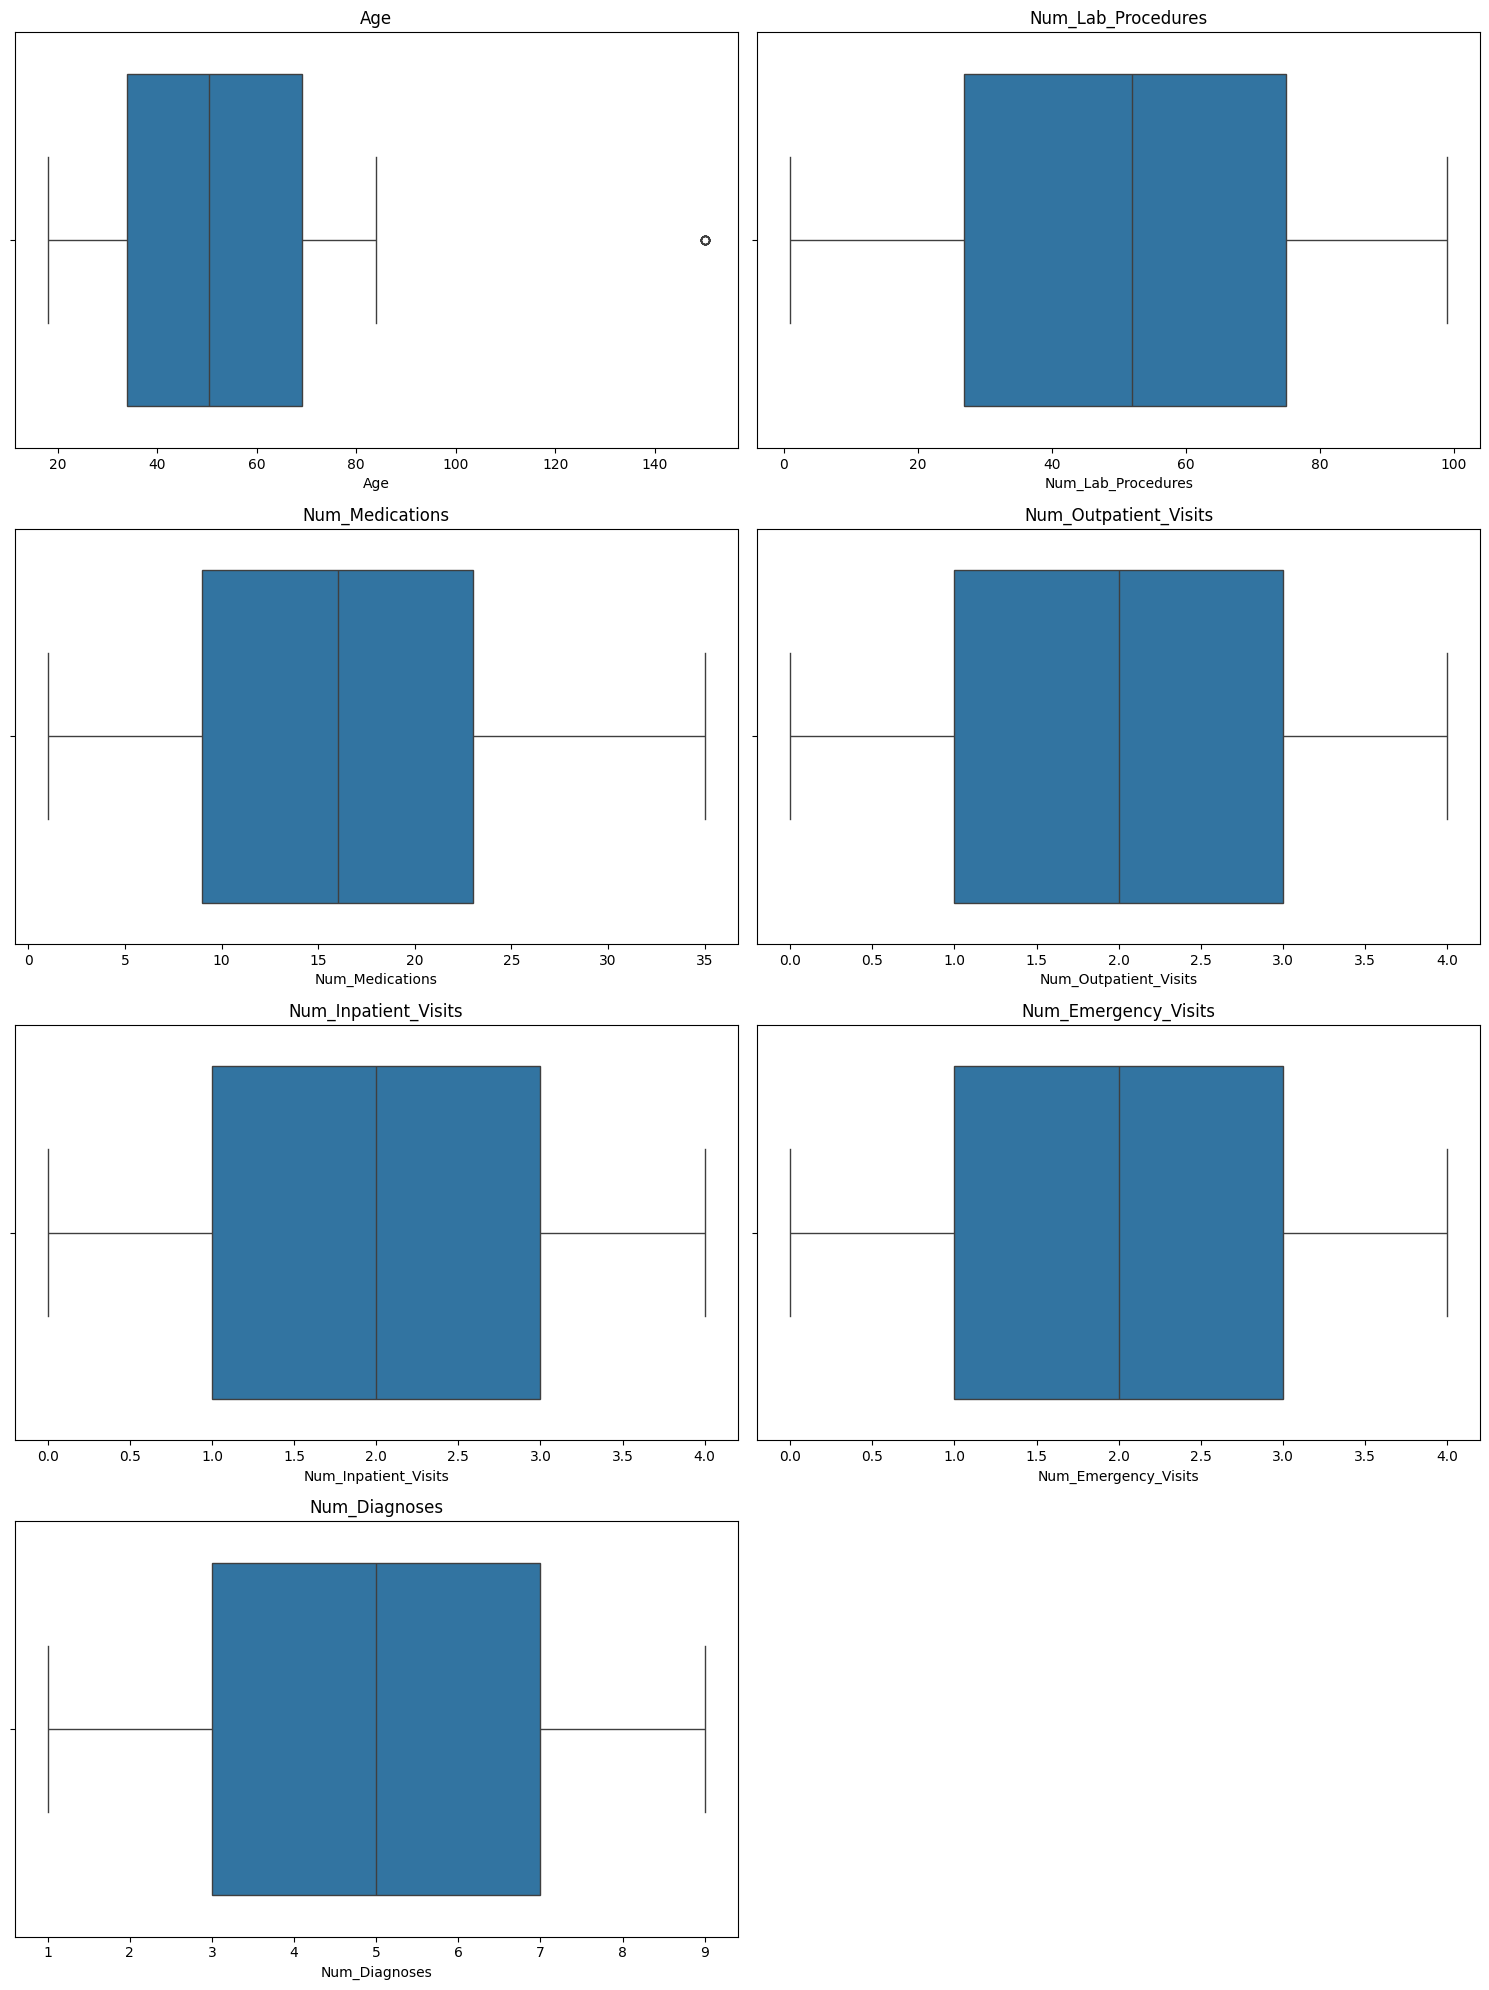

In [405]:
columns_box_plot = ['Age', 'Num_Lab_Procedures', 'Num_Medications', 'Num_Outpatient_Visits', 'Num_Inpatient_Visits', 'Num_Emergency_Visits', 'Num_Diagnoses']
required_plots = len(columns_box_plot)
grid_columns = 2
grid_rows = (required_plots + grid_columns - 1) // grid_columns
fig, axes = plt.subplots(grid_rows, grid_columns, figsize = (15, 20))
axes = axes.flatten()

for i, column in enumerate(columns_box_plot):
    sns.boxplot(x = df[column], ax=axes[i])
    axes[i].set_title(column)

for j in range(required_plots, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()


* From the above box plots, it is clear that age column has outliers.
* Let's find the age outliers data using IQR method

In [406]:
# Find the age column outlier values using IQR
Q1 = df["Age"].quantile(.25)
Q3 = df["Age"].quantile(.75)

IQR = Q3 - Q1
lower_threshold = Q1 - 1.5 * IQR
upper_threshold  = Q3 + 1.5 * IQR

age_outliers = df[(df["Age"] < lower_threshold) | (df["Age"] > upper_threshold)]
age_outliers

,Age,Gender,Admission_Type,Diagnosis,Num_Lab_Procedures,Num_Medications,Num_Outpatient_Visits,Num_Inpatient_Visits,Num_Emergency_Visits,Num_Diagnoses,A1C_Result,Readmitted
50,150,Other,Urgent,Diabetes,88,10,4,3,4,5,Abnormal,Yes
51,150,Other,Emergency,Diabetes,86,22,1,2,3,2,Abnormal,Yes
52,150,Female,Urgent,Injury,93,19,0,1,3,8,Normal,Yes
53,150,Female,Elective,Diabetes,86,1,1,0,4,9,Normal,Yes
54,150,Other,Elective,Diabetes,44,7,3,3,4,4,NaN,Yes
55,150,Other,Elective,Diabetes,9,4,2,4,0,6,Normal,Yes
56,150,Female,Emergency,Diabetes,37,1,1,2,4,8,Abnormal,Yes
57,150,Female,Urgent,Injury,74,15,2,0,3,9,Abnormal,Yes
58,150,Male,Emergency,Diabetes,36,8,0,4,4,5,Normal,No
59,150,Male,Urgent,Infection,92,12,4,4,0,6,Abnormal,Yes


* Let's fix the outliers with updating the age of patient with the mean of ages of patients having similar medical condition.

In [407]:
df_age_below_150 = df[df["Age"] < 150]
df_age_150 = df[df["Age"] == 150]

def update_age_outlier(row):
    gender = row["Gender"]
    admission_type = row['Admission_Type']
    diagnosis = row['Diagnosis']
    num_lab_procedures = row['Num_Lab_Procedures']
    num_medications = row['Num_Medications']
    num_diagnoses = row['Num_Diagnoses']
    
    similar_patients = df_age_below_150[
        (df_age_below_150['Gender'] == gender) & 
        (df_age_below_150['Admission_Type'] == admission_type) & 
        (df_age_below_150['Diagnosis'] == diagnosis) & 
        (df_age_below_150['Num_Lab_Procedures'] > num_lab_procedures - 18) &
        (df_age_below_150['Num_Lab_Procedures'] < num_lab_procedures + 18) &
        (df_age_below_150['Num_Medications'] > num_medications - 5) &
        (df_age_below_150['Num_Medications'] < num_medications + 5)
    ]

    if not similar_patients.empty:
        return int(similar_patients["Age"].mean())
    else:
        return row["Age"]

df_age_150["Age"] = df_age_150.apply(update_age_outlier, axis=1)
df.loc[df["Age"] == 150, "Age"] = df_age_150["Age"]

C:\Users\USER\AppData\Local\Temp\ipykernel_11204\2697239408.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_age_150["Age"] = df_age_150.apply(update_age_outlier, axis=1)


Text(0.5, 1.0, 'Age')

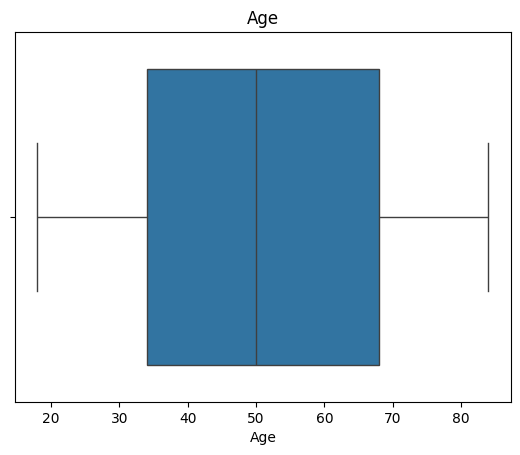

In [408]:
sns.boxplot(x = df["Age"])
plt.title("Age")

In [409]:
df["Age"].describe()

count    1000.000000
mean       50.662000
std        19.714472
min        18.000000
25%        34.000000
50%        50.000000
75%        68.000000
max        84.000000
Name: Age, dtype: float64

In [410]:
df["Readmitted"].value_counts()

Readmitted
No     503
Yes    497
Name: count, dtype: int64

* Column "Readmitted" is the dependent variable.
* Obviously the problem statement is a case of binary classification.
* In here it is clear that the dataset is fairly balanced, with 503 instances of "No" and 497 instances of "Yes" and hence no class imbalance.

Text(0.5, 1.0, 'Patient Readmitted Info')

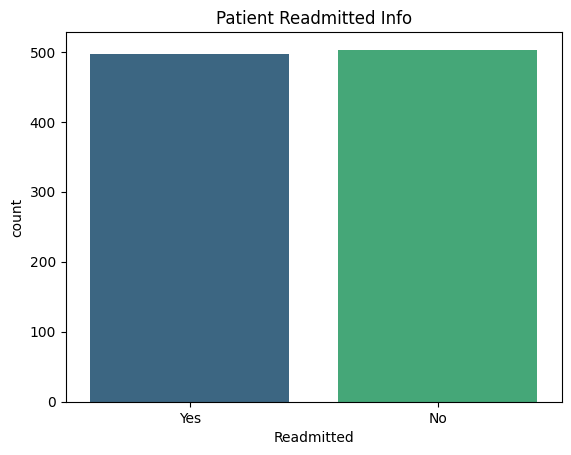

In [411]:
sns.countplot(data=df, x="Readmitted", palette="viridis")
plt.title("Patient Readmitted Info")


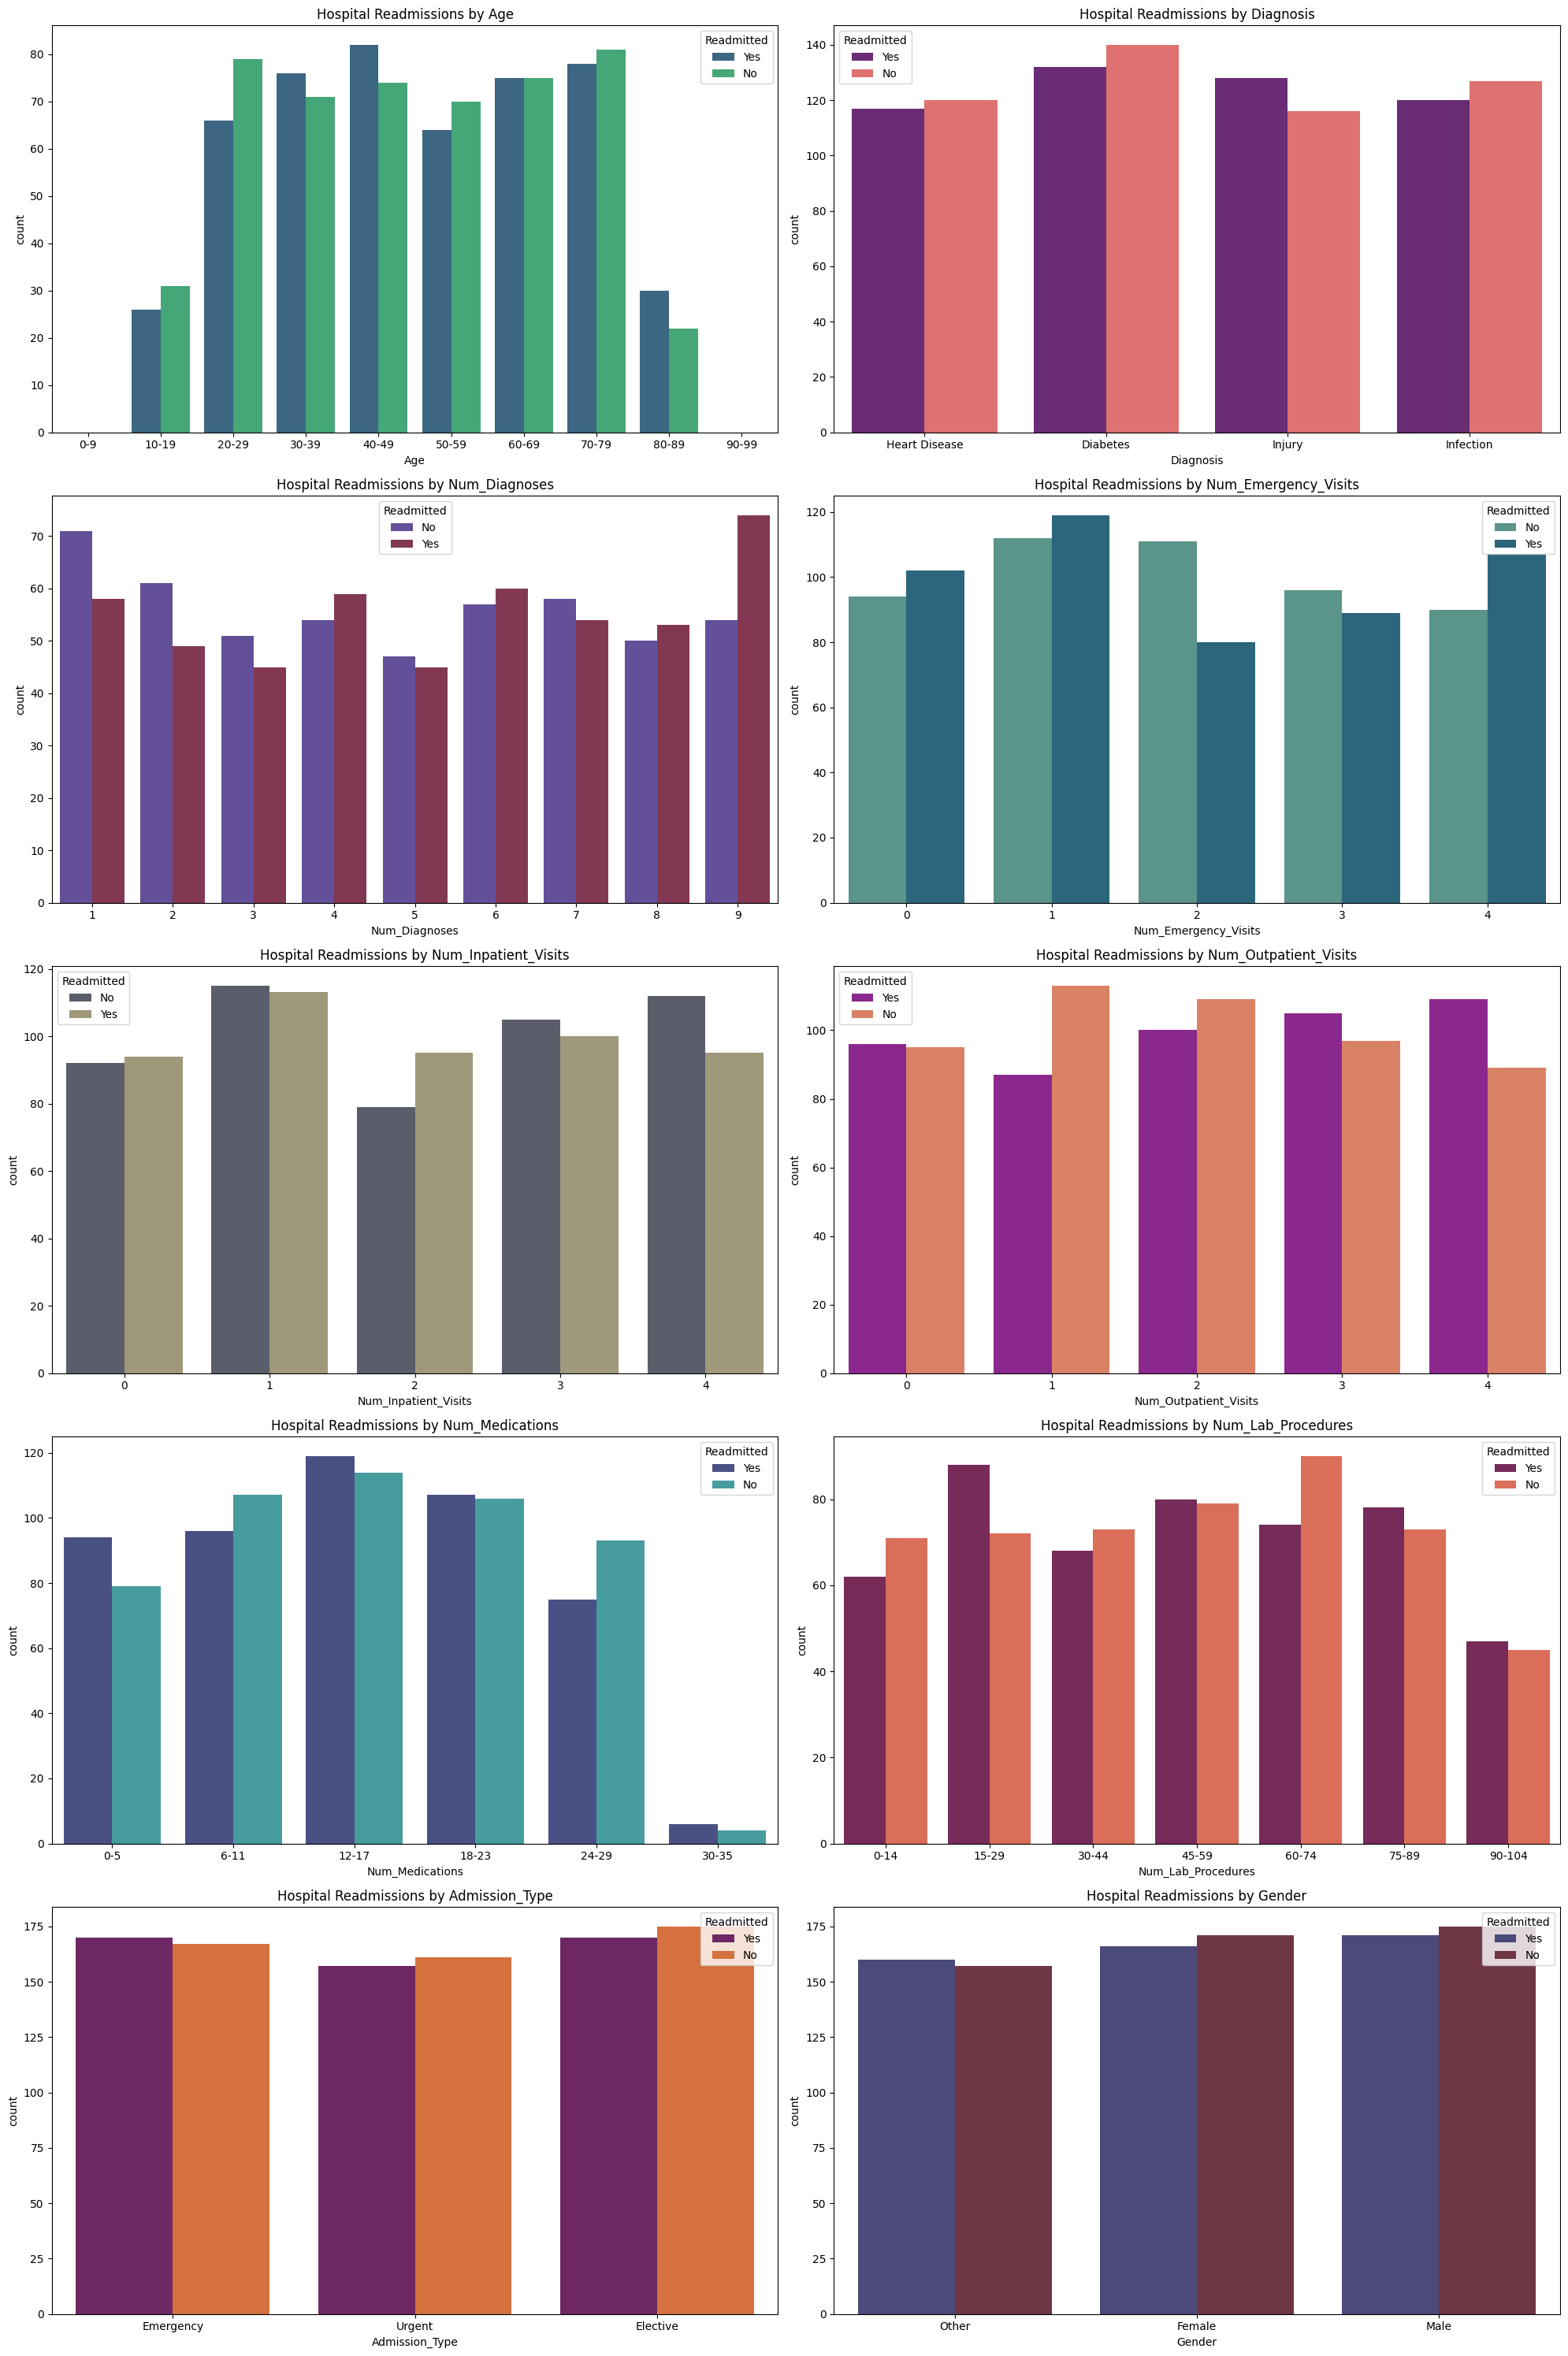

In [412]:
fig, axes = plt.subplots(5, 2, figsize = (20, 30))
axes = axes.flatten()

age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
age_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99']
sns.countplot(data=df, x=pd.cut(df['Age'], bins=age_bins, labels=age_labels), hue='Readmitted', palette="viridis", ax=axes[0])
axes[0].set_title("Hospital Readmissions by Age")

sns.countplot(data=df, x="Diagnosis", hue='Readmitted', palette="magma", ax=axes[1])
axes[1].set_title("Hospital Readmissions by Diagnosis")

sns.countplot(data=df, x="Num_Diagnoses", hue='Readmitted', palette="twilight", ax=axes[2])
axes[2].set_title("Hospital Readmissions by Num_Diagnoses")

sns.countplot(data=df, x="Num_Emergency_Visits", hue='Readmitted', palette="crest", ax=axes[3])
axes[3].set_title("Hospital Readmissions by Num_Emergency_Visits")

sns.countplot(data=df, x="Num_Inpatient_Visits", hue='Readmitted', palette="cividis", ax=axes[4])
axes[4].set_title("Hospital Readmissions by Num_Inpatient_Visits")

sns.countplot(data=df, x="Num_Outpatient_Visits", hue='Readmitted', palette="plasma", ax=axes[5])
axes[5].set_title("Hospital Readmissions by Num_Outpatient_Visits")

medication_bins = [0, 6, 12, 18, 24, 30, 36]
medication_labels = ['0-5', '6-11', '12-17', '18-23', '24-29', '30-35']
sns.countplot(data=df, x=pd.cut(df["Num_Medications"], bins=medication_bins, labels=medication_labels), hue='Readmitted', palette="mako", ax=axes[6])
axes[6].set_title("Hospital Readmissions by Num_Medications")

lab_procedures_bins = [0, 15, 30, 45, 60, 75, 90, 105]
lab_procedures_labels = ['0-14', '15-29', '30-44', '45-59', '60-74', '75-89', '90-104']
sns.countplot(data=df, x=pd.cut(df["Num_Lab_Procedures"], bins=lab_procedures_bins, labels=lab_procedures_labels), hue='Readmitted', palette="rocket", ax=axes[7])
axes[7].set_title("Hospital Readmissions by Num_Lab_Procedures")

sns.countplot(data=df, x="Admission_Type", hue='Readmitted', palette="inferno", ax=axes[8])
axes[8].set_title("Hospital Readmissions by Admission_Type")

sns.countplot(data=df, x="Gender", hue='Readmitted', palette="icefire", ax=axes[9])
axes[9].set_title("Hospital Readmissions by Gender")

plt.tight_layout()


* Above plots showcase the relationship between hospital readmissions and various variables like age, diagnosis, etc. Each plot provides insights into how hospital readmissions are distributed across different categories of these variables.
* From the age plot it is clear that middle age group people visit hospitals more than the young age and old age group people. And so the count of readmission is more in the middle age group.
* Old age group people and middle age groups, particularly those between 30-50, are more vulnerable to health issues leading to readmissions.
* More people visit hospital due to diabetics.
* Readmission rate for injury is more compared to other diagnosis.
* People with most number of diagnosis have higher chance of getting readmitted.
* Emergency cases have higher readmission rate than urgent and elective visits, possibly due to the prevalence of injury cases among emergency admissions.

Text(0.5, 1.0, 'Scatter Plot: Num_Outpatient_Visits')

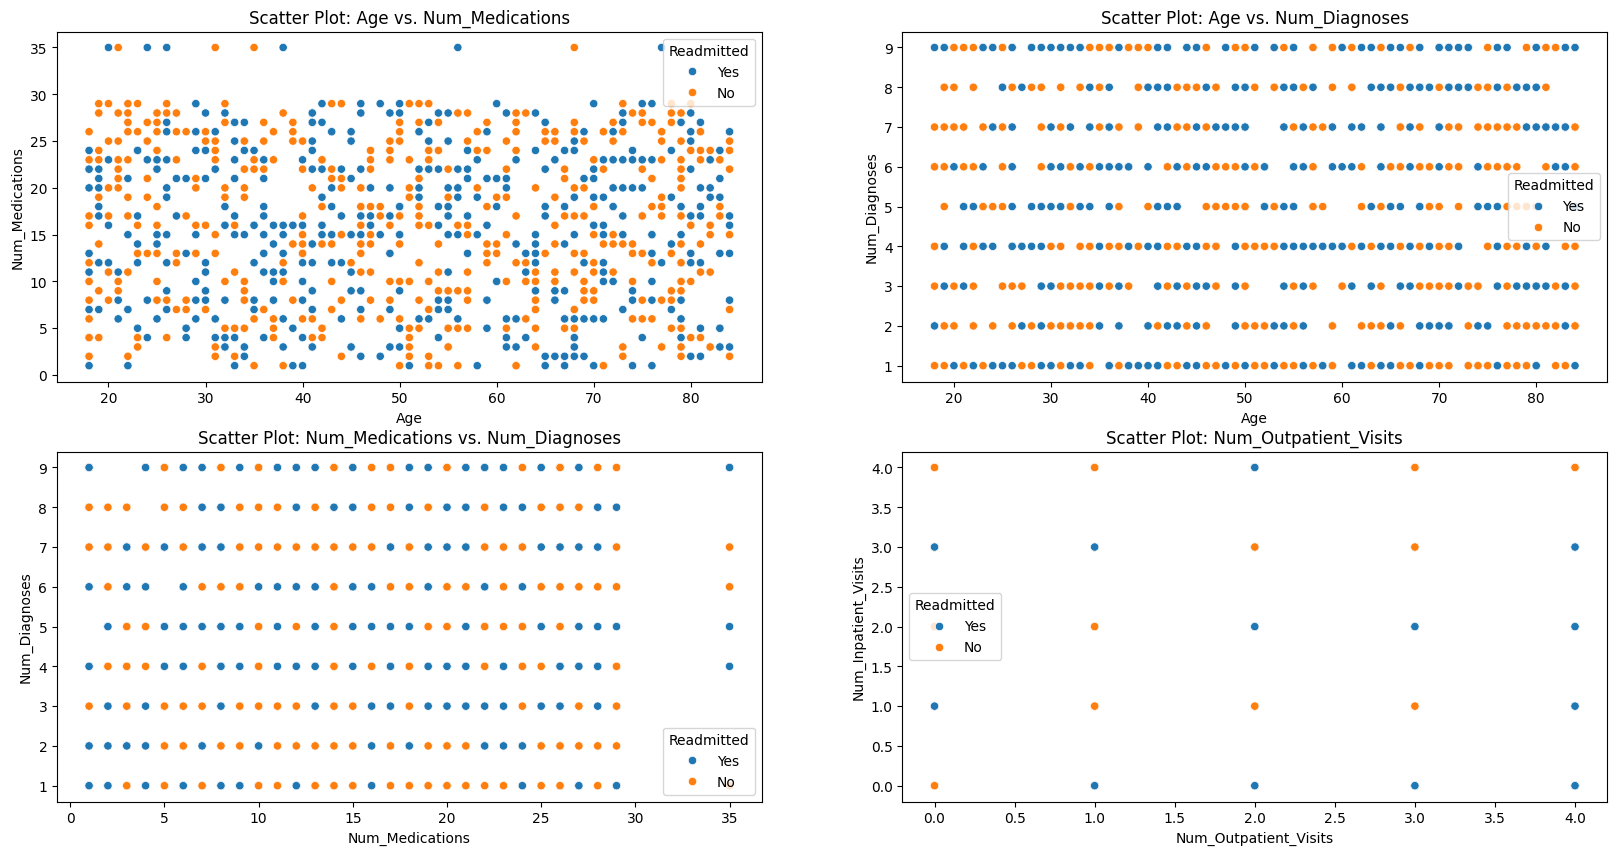

In [413]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
sns.scatterplot(data=df, x='Age', y='Num_Medications', hue='Readmitted')
plt.title('Scatter Plot: Age vs. Num_Medications')

plt.subplot(2, 2, 2)
sns.scatterplot(data=df, x='Age', y='Num_Diagnoses', hue='Readmitted')
plt.title('Scatter Plot: Age vs. Num_Diagnoses')

plt.subplot(2, 2, 3)
sns.scatterplot(data=df, x='Num_Medications', y='Num_Diagnoses', hue='Readmitted')
plt.title('Scatter Plot: Num_Medications vs. Num_Diagnoses')

plt.subplot(2, 2, 4)
sns.scatterplot(data=df, x='Num_Outpatient_Visits', y='Num_Inpatient_Visits', hue='Readmitted')
plt.title('Scatter Plot: Num_Outpatient_Visits')


In [414]:
# points

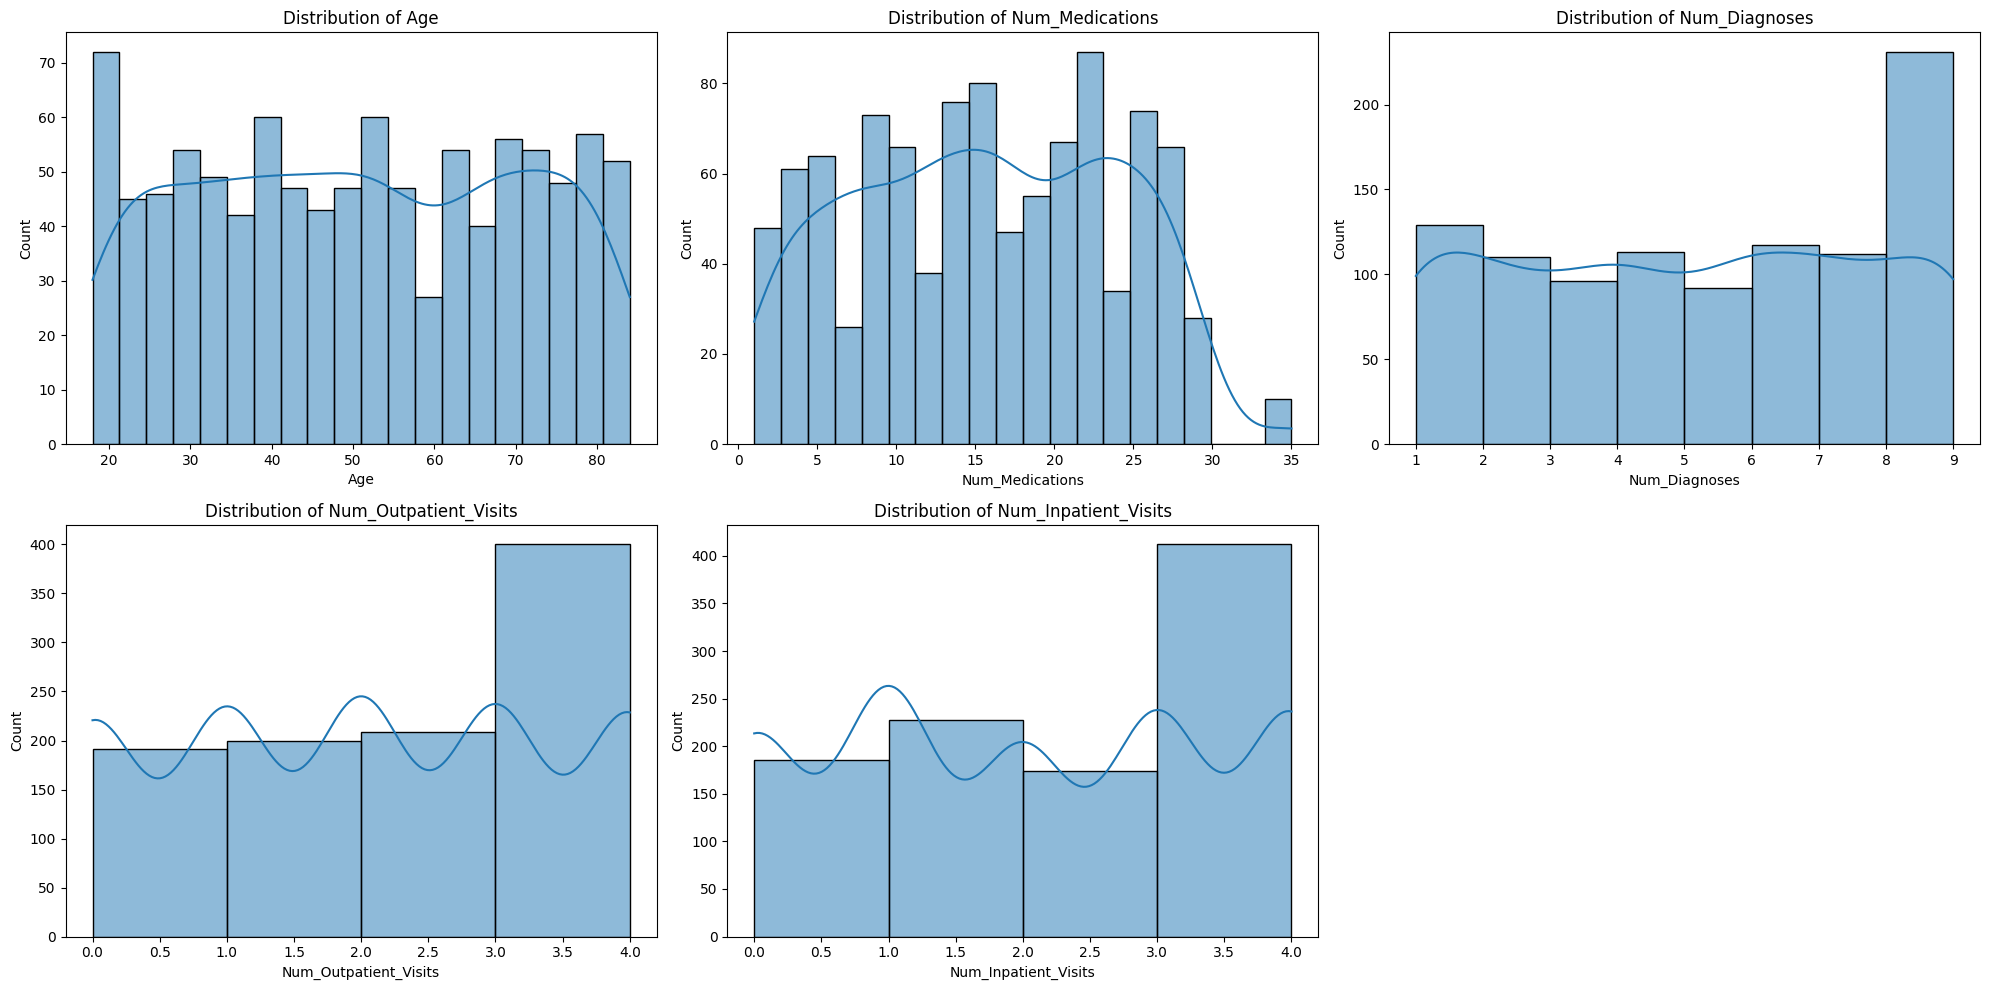

In [415]:
# Distribution Plots
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
sns.histplot(df['Age'], kde=True, bins=20)
plt.title('Distribution of Age')

plt.subplot(2, 3, 2)
sns.histplot(df['Num_Medications'], kde=True, bins=20)
plt.title('Distribution of Num_Medications')

plt.subplot(2, 3, 3)
sns.histplot(df['Num_Diagnoses'], kde=True, bins=8)
plt.title('Distribution of Num_Diagnoses')

plt.subplot(2, 3, 4)
sns.histplot(df['Num_Outpatient_Visits'], kde=True, bins=4)
plt.title('Distribution of Num_Outpatient_Visits')

plt.subplot(2, 3, 5)
sns.histplot(df['Num_Inpatient_Visits'], kde=True, bins=4)
plt.title('Distribution of Num_Inpatient_Visits')

plt.tight_layout()
plt.show()

In [416]:
#points

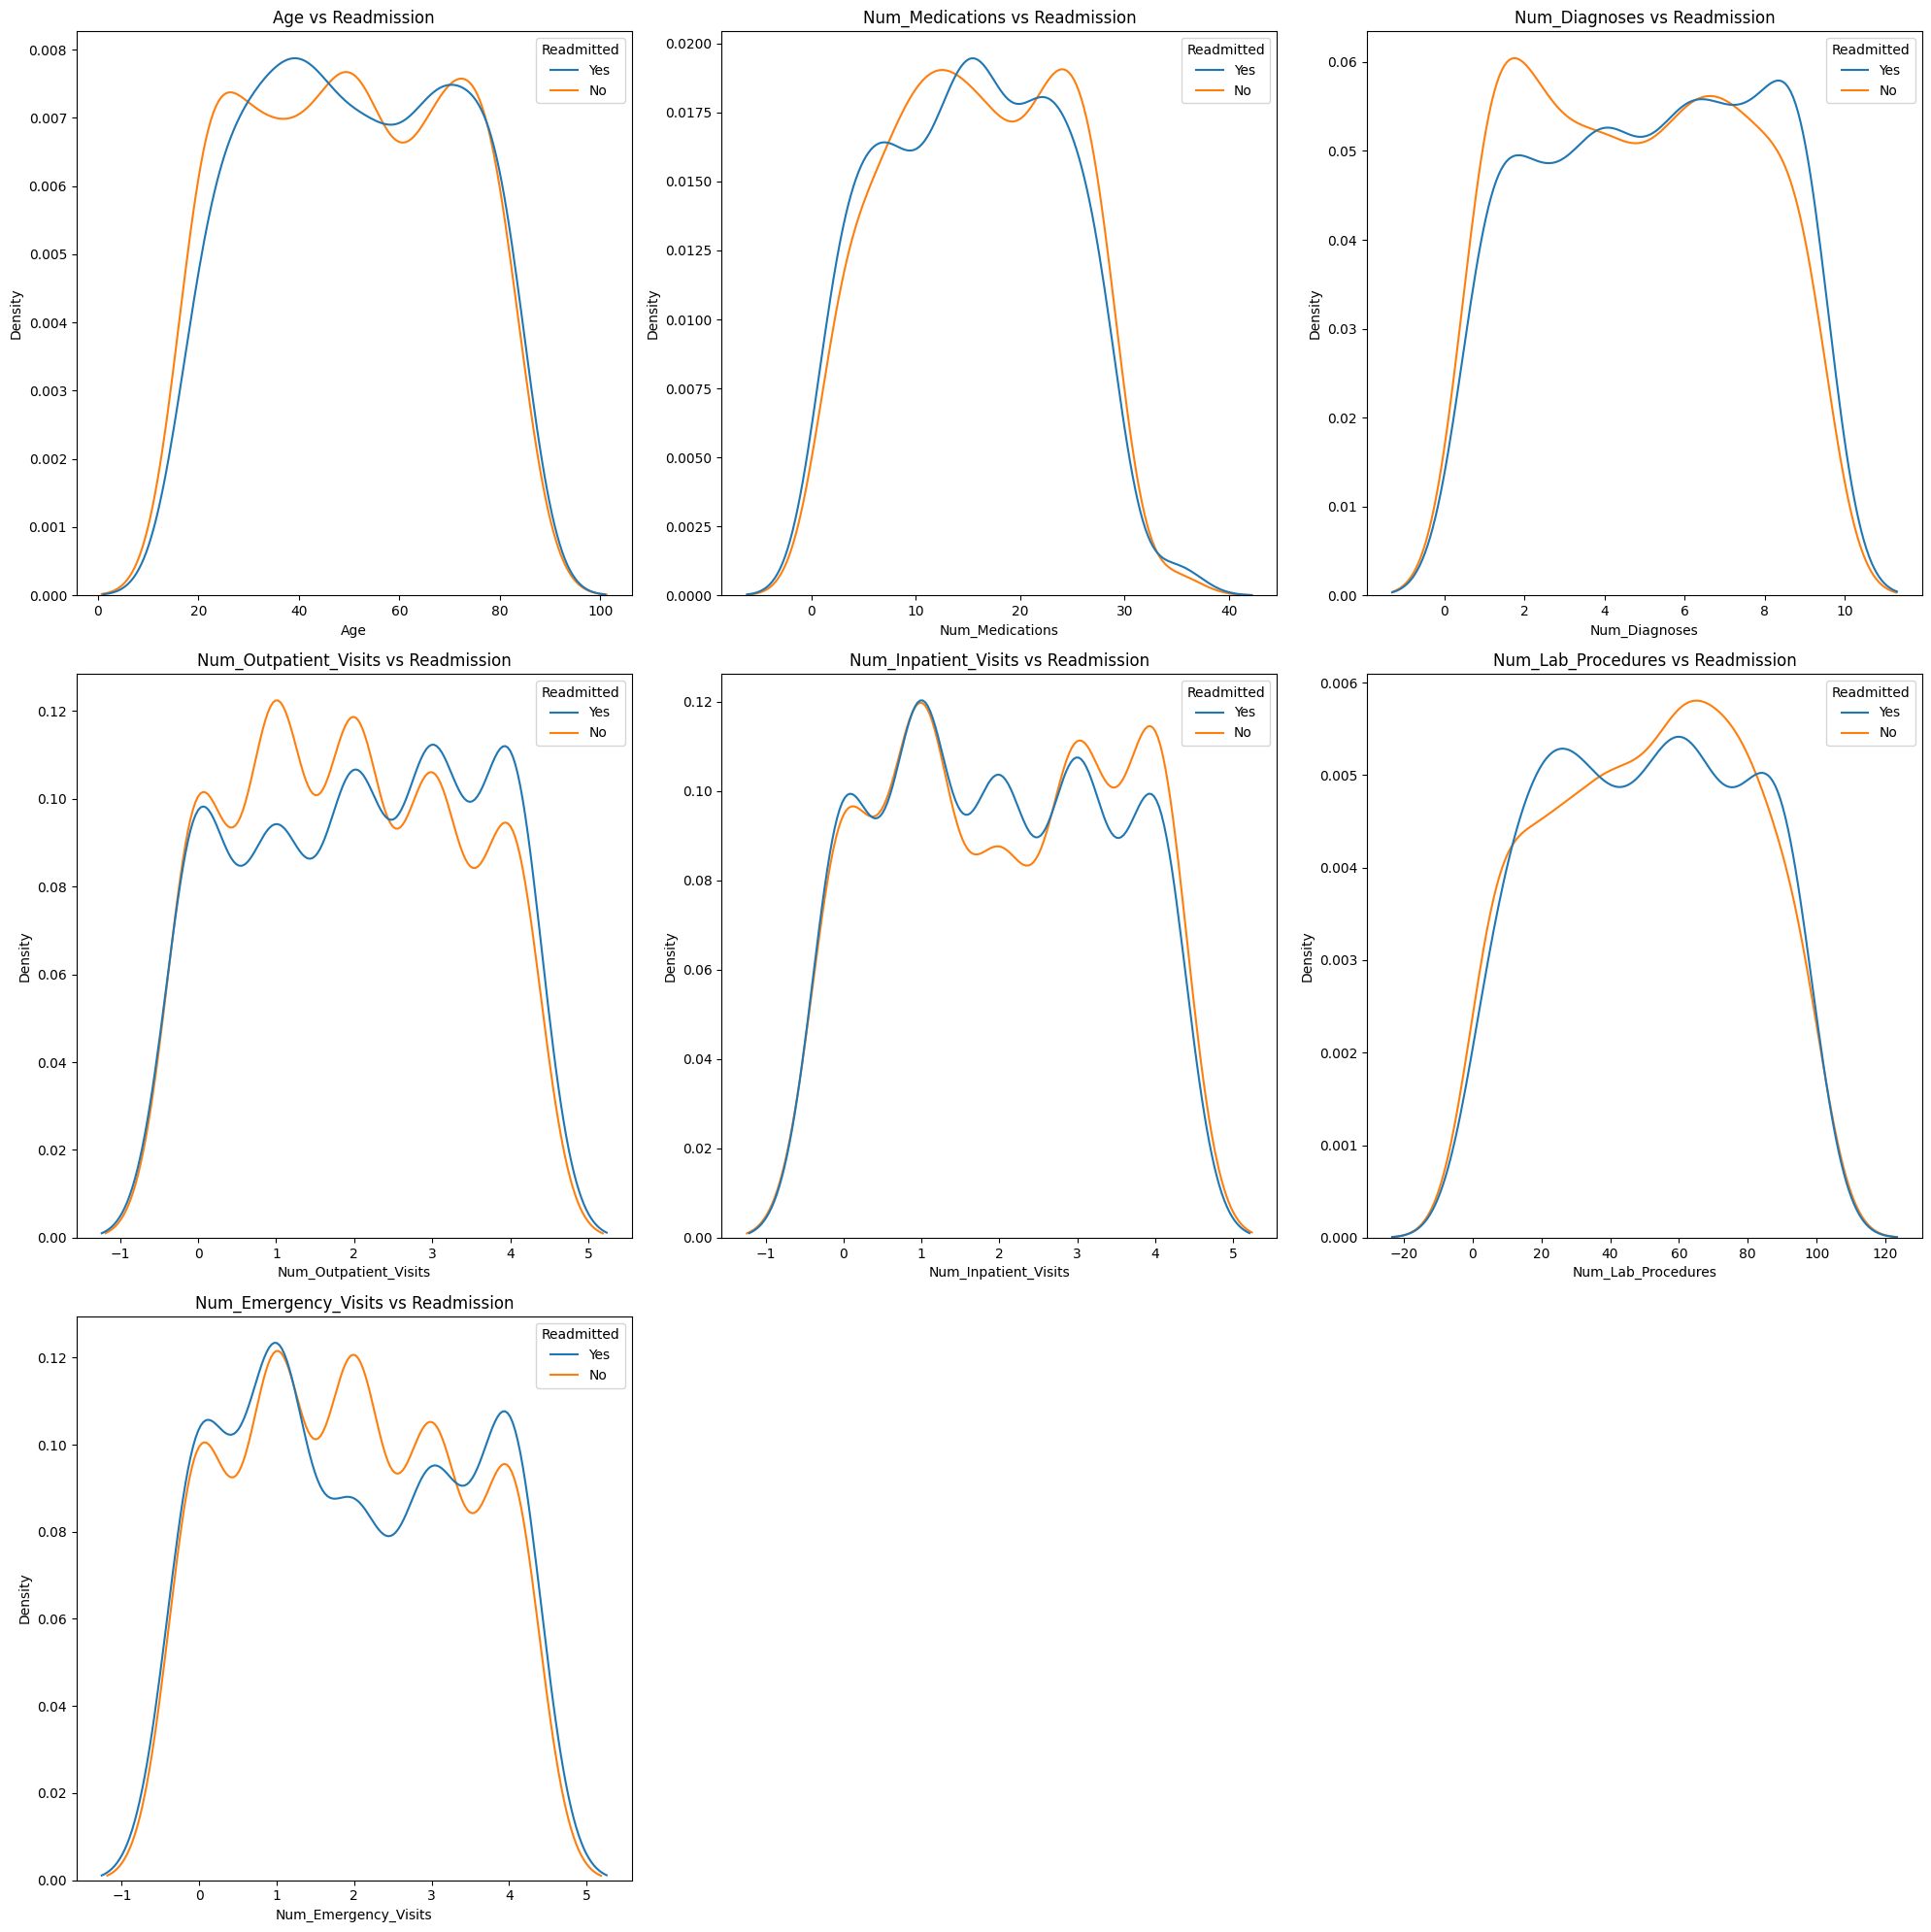

In [417]:
plt.figure(figsize=(20, 20))

plt.subplot(3, 3, 1)
sns.kdeplot(df, x="Age", hue= 'Readmitted')
plt.title('Age vs Readmission')

plt.subplot(3, 3, 2)
sns.kdeplot(df, x="Num_Medications", hue= 'Readmitted')
plt.title('Num_Medications vs Readmission')

plt.subplot(3, 3, 3)
sns.kdeplot(df, x="Num_Diagnoses", hue= 'Readmitted')
plt.title('Num_Diagnoses vs Readmission')

plt.subplot(3, 3, 4)
sns.kdeplot(df, x="Num_Outpatient_Visits", hue= 'Readmitted')
plt.title('Num_Outpatient_Visits vs Readmission')

plt.subplot(3, 3, 5)
sns.kdeplot(df, x="Num_Inpatient_Visits", hue= 'Readmitted')
plt.title('Num_Inpatient_Visits vs Readmission')

plt.subplot(3, 3, 6)
sns.kdeplot(df, x="Num_Lab_Procedures", hue= 'Readmitted')
plt.title('Num_Lab_Procedures vs Readmission')

plt.subplot(3, 3, 7)
sns.kdeplot(df, x="Num_Emergency_Visits", hue= 'Readmitted')
plt.title('Num_Emergency_Visits vs Readmission')

plt.tight_layout()
plt.show()

#points

##### Handle A1C_Result

In [418]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score
# from sklearn.ensemble import RandomForestRegressor
# impute_data = df.dropna(subset=['A1C_Result'])
# X_impute = impute_data.drop(columns=['A1C_Result'])
# y_impute = impute_data['A1C_Result']
# # Train-test split
# X_train_a1c, X_test_a1c, y_train_a1c, y_test_a1c = train_test_split(X_impute, y_impute, test_size=0.2, random_state=42)
# # Train imputation model (e.g., logistic regression)

# # Initialize LabelEncoder
# label_encoder = LabelEncoder()

# # Fit label encoder and transform target variable
# y_train_a1c = label_encoder.fit_transform(y_train_a1c)
# y_test_a1c = label_encoder.transform(y_test_a1c)

# # One hot encoding on categorical independent variables
# X_train_a1c = pd.get_dummies(X_train_a1c, dtype=int)
# X_test_a1c =pd.get_dummies(X_test_a1c, dtype=int)

# # "Align" to Ensure the columns match between train and test sets
# X_train_a1c, X_test_a1c = X_train_a1c.align(X_test_a1c, join='left', axis=1, fill_value=0)

# impute_model = LogisticRegression()
# impute_model.fit(X_train_a1c, y_train_a1c)
# acc = accuracy_score(y_test_a1c, impute_model.predict(X_test_a1c))
# print(acc)
# # Predict missing values
# missing_mask = df['A1C_Result'].isnull()
# X_missing = df[missing_mask].drop(columns=['A1C_Result'])

# # One hot encoding on the missing data
# X_missing = pd.get_dummies(X_missing, dtype=int)

# # Align columns
# X_missing, X_train_a1c = X_missing.align(X_train_a1c, join='left', axis=1, fill_value=0)

# # Predict and inverse transform to original labels
# df.loc[missing_mask, 'A1C_Result'] = label_encoder.inverse_transform(impute_model.predict(X_missing))

# # Now the DataFrame `df` has imputed A1C_Result values
# print(df)

In [419]:
# Distribution of A1C_Result values and count missing values
df["A1C_Result"].value_counts(dropna=False)

A1C_Result
NaN         434
Abnormal    301
Normal      265
Name: count, dtype: int64

* There are substantial number of missing values in the "A1C_Result" column.

In [423]:
df.groupby('Diagnosis')['A1C_Result'].value_counts(dropna=False).unstack()

A1C_Result,Abnormal,Normal,NaN
Diagnosis,,,
Diabetes,89,73,110
Heart Disease,67,62,108
Infection,70,63,114
Injury,75,67,102


* Misssing A1C_Result value is randomly spread across all the type of diagnosis.
* It is not logical to predict the empty A1C_Result value using the non-empty rows as almost all the dataset features does not effect the A1C_Result logically.
* So creating a separate category for the empty "A1C_Result" might be the most appropriate approach.

In [424]:
# filling missing values in "A1C_Result" column with term 'Missing'
df['A1C_Result'].fillna('Missing', inplace=True)

In [425]:
readmission_rates = df.groupby('A1C_Result')['Readmitted'].value_counts(normalize=True).unstack()
readmission_rates

Readmitted,No,Yes
A1C_Result,,
Abnormal,0.465116,0.534884
Missing,0.509217,0.490783
Normal,0.535849,0.464151


* Readmissions are more when A1C_Result is abnormal 
* The differences in readmission rates across A1C_Result categories are relatively minor.

Text(0.5, 1.0, 'Hospital Readmission By A1C_Result')

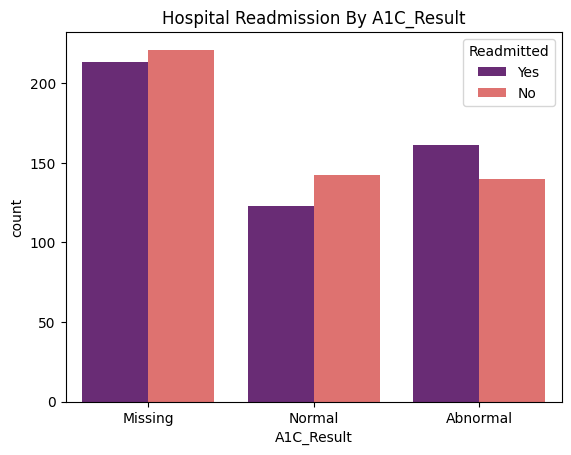

In [426]:
sns.countplot(df, x="A1C_Result", hue='Readmitted', palette="magma")
plt.title('Hospital Readmission By A1C_Result')

In [427]:
df

,Age,Gender,Admission_Type,Diagnosis,Num_Lab_Procedures,Num_Medications,Num_Outpatient_Visits,Num_Inpatient_Visits,Num_Emergency_Visits,Num_Diagnoses,A1C_Result,Readmitted
0,69,Other,Emergency,Heart Disease,33,2,4,1,1,5,Missing,Yes
1,32,Female,Urgent,Diabetes,81,10,4,4,1,6,Missing,No
2,78,Female,Urgent,Heart Disease,75,29,4,0,3,5,Normal,No
3,38,Male,Elective,Diabetes,77,11,2,3,4,9,Missing,Yes
4,41,Female,Urgent,Diabetes,50,25,3,4,1,3,Missing,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...
995,21,Female,Emergency,Heart Disease,68,10,2,3,2,9,Normal,No
996,43,Female,Emergency,Heart Disease,61,7,0,4,0,1,Normal,No
997,75,Male,Urgent,Diabetes,29,13,3,1,4,8,Normal,No
998,46,Other,Elective,Injury,19,20,1,4,4,1,Abnormal,No


Perform train-test split

In [428]:
X = df.drop(columns=["Readmitted"])
y = df["Readmitted"]

In [429]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

To simplify the modeling process, we are grouping few of the features

In [430]:

age_bins = [15, 30, 60, 90]
age_labels = ['Young_Aged', 'Middle_Aged', 'Old_Aged'] # [15-29, 30-59, 60-89]
X_train['Age_Group'] = pd.cut(X_train['Age'], bins=age_bins, labels=age_labels, right=False)


num_diagnosis_bins = [0, 3, 6, 10]  
num_diagnosis_labels = ['Low', 'Medium', 'High'] # [0-2, 3-5, 6-9]
X_train['Num_Diagnoses_Group'] = pd.cut(X_train['Num_Diagnoses'], bins=num_diagnosis_bins, labels=num_diagnosis_labels)


num_medications_bins = [0, 10, 20, 36]
num_medications_labels = ['Low', 'Medium', 'High'] # [0-9, 10-19, 20-35]
X_train['Num_Medications_Group'] = pd.cut(X_train['Num_Medications'], bins=num_medications_bins, labels=num_medications_labels)

num_lab_procedures_bins = [0, 10, 20, 36]
num_lab_procedures_labels = ['Low', 'Medium', 'High'] # [0-9, 10-19, 20-35]
X_train['Num_Lab_Procedures_Group'] = pd.cut(X_train['Num_Lab_Procedures'], bins=num_lab_procedures_bins, labels=num_lab_procedures_labels)

X_test['Age_Group'] = pd.cut(X_test['Age'], bins=age_bins, labels=age_labels, right=False)

X_test['Num_Diagnoses_Group'] = pd.cut(X_test['Num_Diagnoses'], bins=num_diagnosis_bins, labels=num_diagnosis_labels)

X_test['Num_Medications_Group'] = pd.cut(X_test['Num_Medications'], bins=num_medications_bins, labels=num_medications_labels)

X_test['Num_Lab_Procedures_Group'] = pd.cut(X_test['Num_Lab_Procedures'], bins=num_lab_procedures_bins, labels=num_lab_procedures_labels)

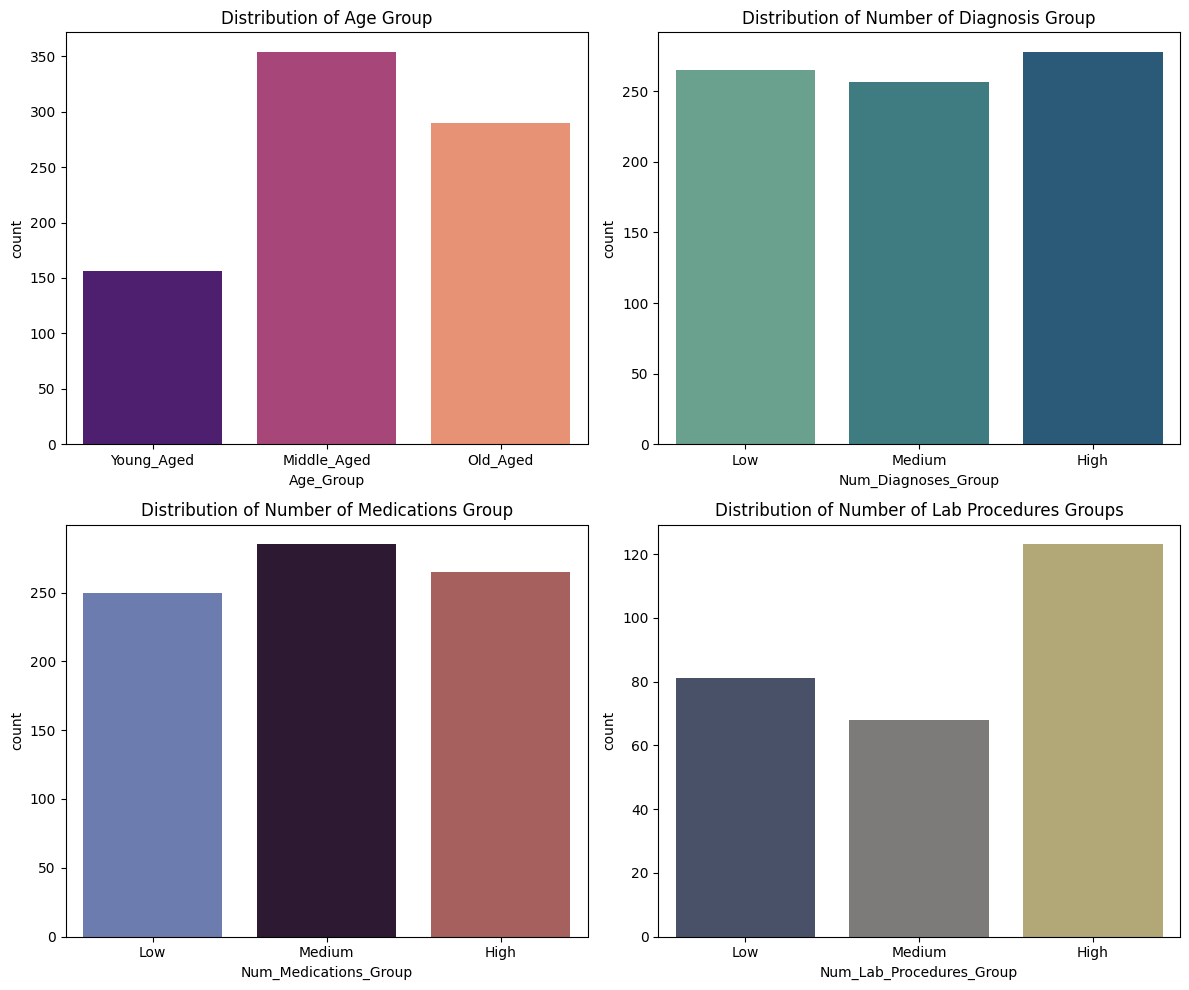

In [431]:
fig, axes = plt.subplots(2, 2, figsize = (12, 10))
axes = axes.flatten()

sns.countplot(data=X_train, x="Age_Group", palette="magma", ax=axes[0])
axes[0].set_title("Distribution of Age Group")

sns.countplot(data=X_train, x="Num_Diagnoses_Group", palette="crest", ax=axes[1])
axes[1].set_title("Distribution of Number of Diagnosis Group")

sns.countplot(data=X_train, x="Num_Medications_Group", palette="twilight", ax=axes[2])
axes[2].set_title("Distribution of Number of Medications Group")


sns.countplot(data=X_train, x="Num_Lab_Procedures_Group", palette="cividis", ax=axes[3])
axes[3].set_title("Distribution of Number of Lab Procedures Groups")

plt.tight_layout()

##### Convert Target variable from categorical to numerical values

In [432]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform target variable
Y_train = label_encoder.fit_transform(Y_train)
Y_test = label_encoder.transform(Y_test)

* Target column values  "Yes" and "No" is encoded as 1 and 0 respectively, as per the label encoding.

##### Convert all categorical independent variables to numerical values

In [433]:
# # List of all categorical columns to be label encoded
# categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object' or X_train[col].dtype == 'category']

# # Initialize label encoders for each categorical column
# label_encoders = {col: LabelEncoder() for col in categorical_cols}

# # Fit and transform the training data
# for col, encoder in label_encoders.items():
#     X_train[col] = encoder.fit_transform(X_train[col])

# # Transform the test data
# for col, encoder in label_encoders.items():
#     X_test[col] = encoder.transform(X_test[col])

In [434]:
# One hot encoding on categorical independent variables
X_train = pd.get_dummies(X_train, dtype=int)
X_test =pd.get_dummies(X_test, dtype=int)

# "Align" to Ensure the columns match between train and test sets
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

Find the correlation of A1C_Result column with other features

In [435]:
# Combine independent vairables with the target variable for the training set
X_train_full = X_train.copy()
X_train_full['Readmitted'] = Y_train

# Calculate correlation matrix
correlation_matrix = X_train_full.corr()

# Correlation of A1C_Result columns with other numerical features
a1c_columns = [col for col in X_train_full.columns if col.startswith('A1C_')]
a1c_correlation = correlation_matrix[a1c_columns]

print("Correlation of A1C_Result columns with other numerical features:")
print(a1c_correlation)

Correlation of A1C_Result columns with other numerical features:
                                 A1C_Result_Abnormal  A1C_Result_Missing  \
Age                                         0.094574           -0.079689   
Num_Lab_Procedures                         -0.046777            0.023304   
Num_Medications                             0.013629            0.005034   
Num_Outpatient_Visits                       0.042921            0.031767   
Num_Inpatient_Visits                       -0.026496            0.061240   
Num_Emergency_Visits                       -0.008507            0.008373   
Num_Diagnoses                               0.081374           -0.041028   
Gender_Female                              -0.010450           -0.022640   
Gender_Male                                 0.005773            0.013563   
Gender_Other                                0.004786            0.009316   
Admission_Type_Elective                    -0.014709           -0.005008   
Admission_Type_Emergenc

* From Correlation matrix, it is clear that:
1) There is no significant correlations between column "A1C_Result" and dependent variable readmission.
2) Also there is no significant correlation between column "A1C_Result" and other independent variables.

Using Chi-Square test to find if there is any significant association of "A1C_Result" with readmission

In [436]:
for column in a1c_columns:
    contingency_table = pd.crosstab(X_train[column], Y_train)
    chi2, p, dof, ex = stats.chi2_contingency(contingency_table)
    
    print(f"\nChi-square test results for {column}:")
    print(f"Chi-square statistic: {chi2}")
    print(f"P-value: {p}")
    print(f"Degrees of freedom: {dof}")

    # Interpret the results
    alpha = 0.05
    if p < alpha:
        print(f"Reject the null hypothesis for {column}: There is a significant association with readmission.")
    else:
        print(f"Fail to reject the null hypothesis for {column}: There is no significant association with readmission.")


Chi-square test results for A1C_Result_Abnormal:
Chi-square statistic: 3.8349149265477207
P-value: 0.050195538337202944
Degrees of freedom: 1
Fail to reject the null hypothesis for A1C_Result_Abnormal: There is no significant association with readmission.

Chi-square test results for A1C_Result_Missing:
Chi-square statistic: 0.1953939750226894
P-value: 0.6584646698768806
Degrees of freedom: 1
Fail to reject the null hypothesis for A1C_Result_Missing: There is no significant association with readmission.

Chi-square test results for A1C_Result_Normal:
Chi-square statistic: 2.0804555626400756
P-value: 0.14919564279731165
Degrees of freedom: 1
Fail to reject the null hypothesis for A1C_Result_Normal: There is no significant association with readmission.


* From Chi-square test results for A1C_Result, it is clear that there is no signicant association with readmission.

Correlation of target variable with independent variables

Correlation of target variable with independent variables:
A1C_Result_Abnormal                0.071987
Age                                0.052151
Num_Lab_Procedures                 0.036884
Num_Diagnoses                      0.035703
Num_Outpatient_Visits              0.035644
Age_Group_Old_Aged                 0.034974
Admission_Type_Emergency           0.030062
Num_Diagnoses_Group_High           0.029900
Num_Medications_Group_Low          0.024946
Diagnosis_Injury                   0.020287
Num_Lab_Procedures_Group_Medium    0.019453
Age_Group_Middle_Aged              0.014522
Gender_Female                      0.014145
Num_Diagnoses_Group_Medium         0.006117
Num_Lab_Procedures_Group_High      0.005597
Diagnosis_Heart Disease            0.002829
Num_Emergency_Visits               0.002497
Admission_Type_Elective           -0.001572
Num_Medications_Group_Medium      -0.004111
Gender_Male                       -0.004519
Diagnosis_Diabetes                -0.005298
Gender_Other     

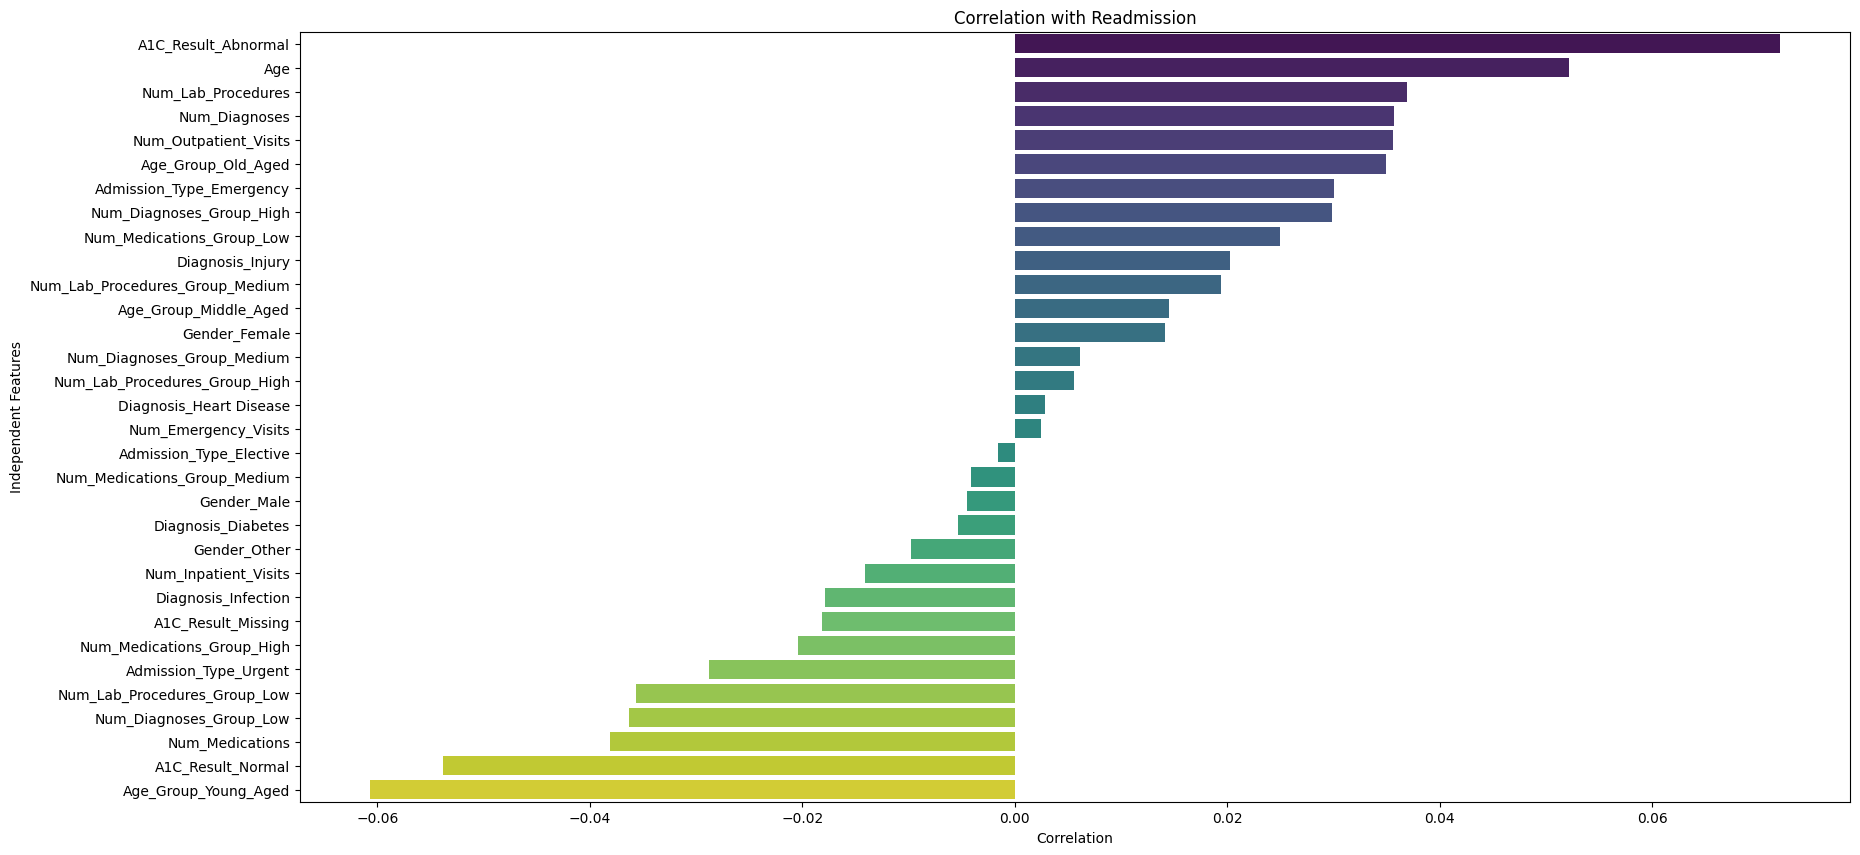

In [437]:
print("Correlation of target variable with independent variables:")
correlation_readmission = correlation_matrix["Readmitted"].sort_values(ascending=False)
correlation_readmission.drop("Readmitted", inplace=True)
print(correlation_readmission)
plt.figure(figsize=(20, 10))
sns.barplot(x=correlation_readmission, y=correlation_readmission.index, palette="viridis")
plt.xlabel("Correlation")
plt.ylabel("Independent Features")
plt.title('Correlation with Readmission')
plt.show()

* Looks like the target variable "Readmitted" does not have any strong dependence on any of the independent variables. Important point to note here is the column "A1C_Result" is the most related to Readmission compared to other inpendent features. So, we are not dropping the "A1C_Result" feature.

Correlation of independent features using Heat Map

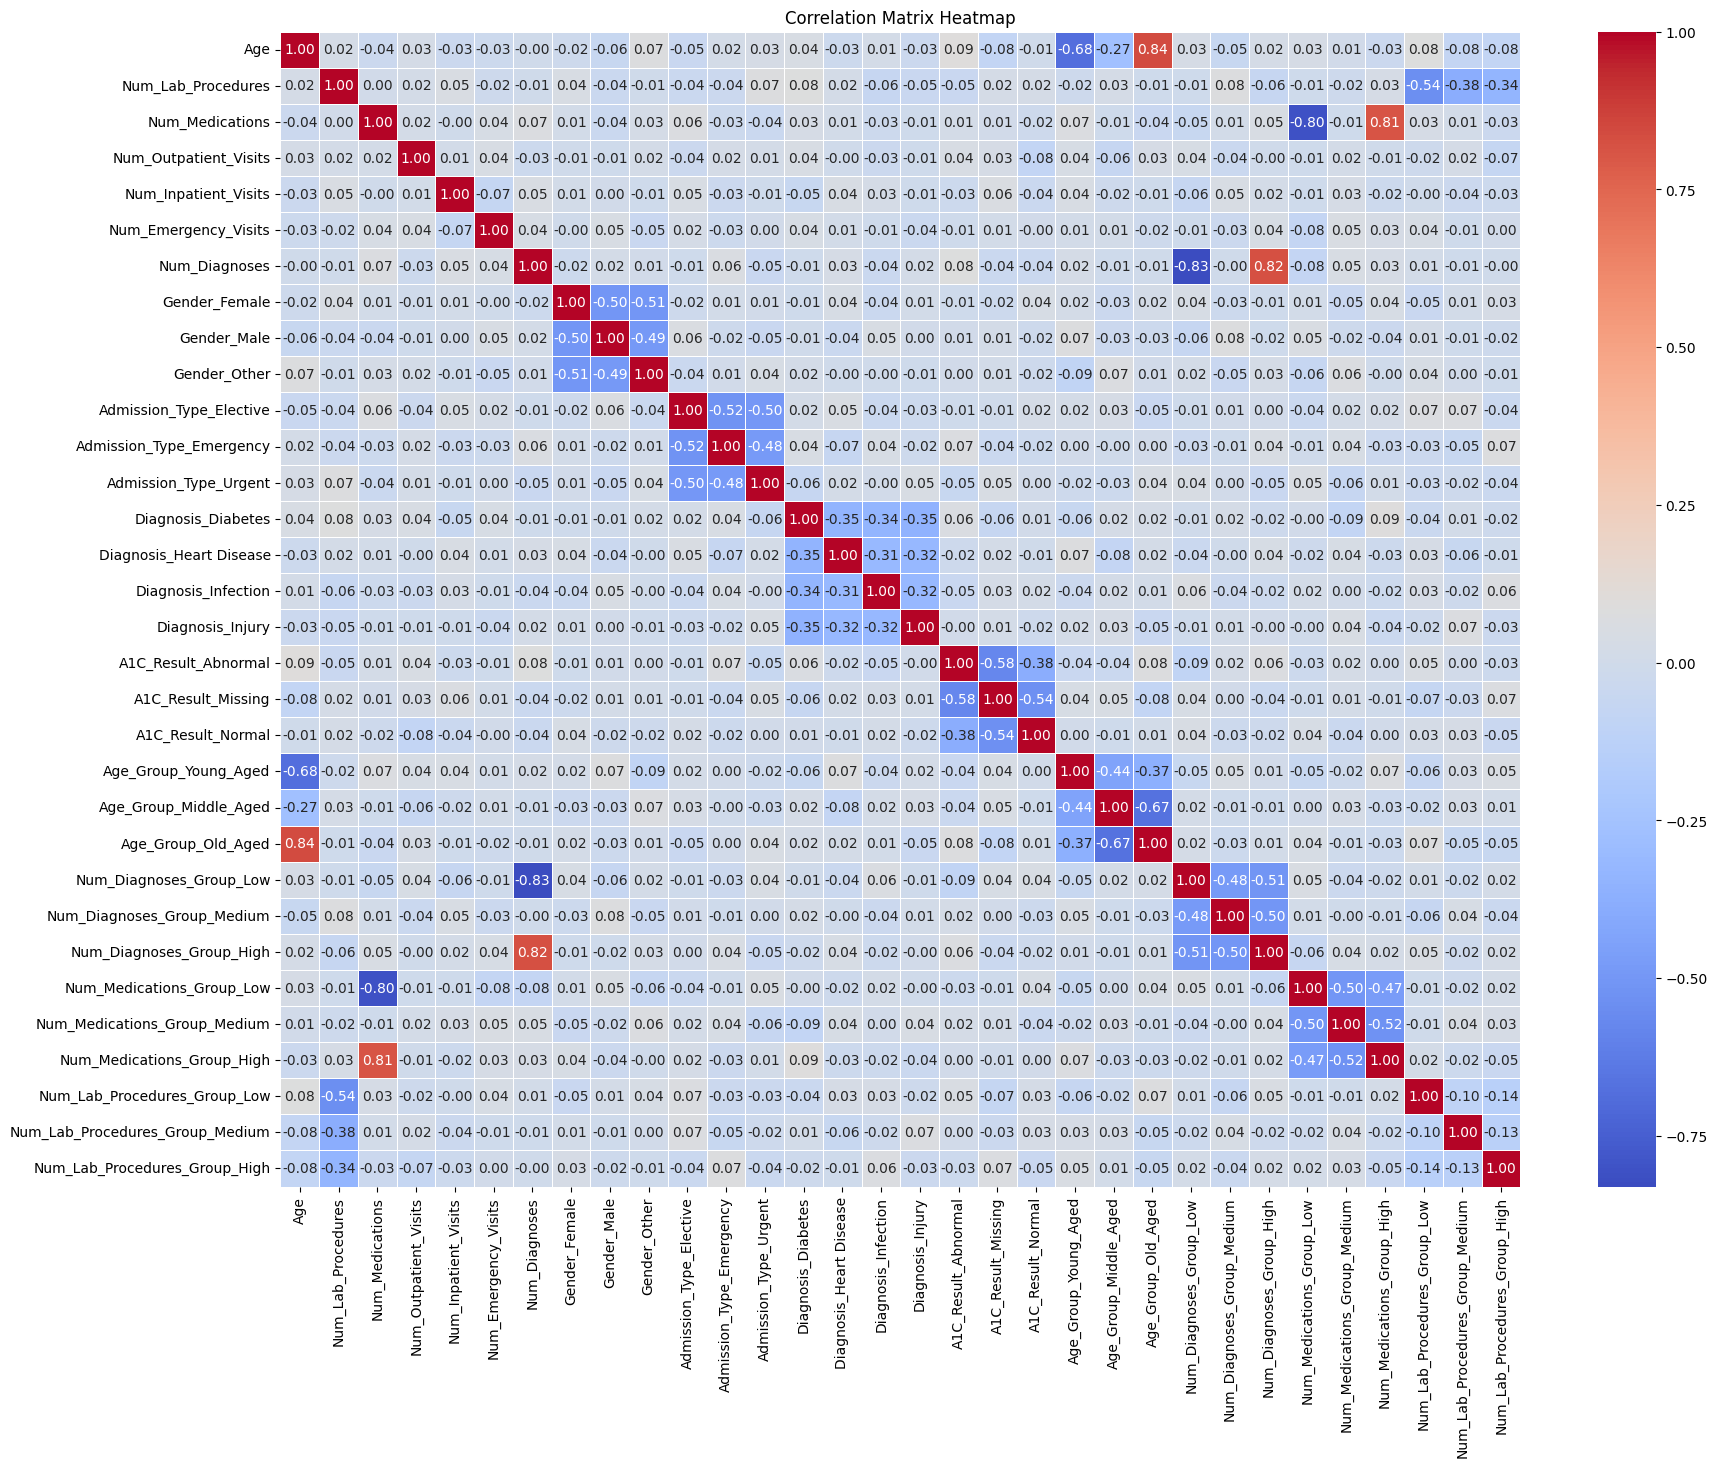

In [438]:
corr = X_train.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

* There is no significant correlation between the independent variables.

Feature Scaling

In [439]:
to_scale_features = X_train.select_dtypes(include=["int64"]).columns.to_list()
to_scale_features

['Age',
 'Num_Lab_Procedures',
 'Num_Medications',
 'Num_Outpatient_Visits',
 'Num_Inpatient_Visits',
 'Num_Emergency_Visits',
 'Num_Diagnoses']

To know which scaling technique is suited for the given dataset, let's first check whether the required features are approximately normally distributed or not.

We will use following statistical methods to check whether the data is normally distributed or not:
1) Shapiro-Wilk Test
2) Kolmogorov-Smirnov Test

In [440]:
# Shapiro-Wilk Test
print("Shapiro-Wilk Test")
for col in to_scale_features:
    feature = X_train[col]
    stat, p = stats.shapiro(feature)
    print(f"\nFor feature '{col}':")
    print(f'Statistics={stat}, p={p}')
    if p > 0.05:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

Shapiro-Wilk Test

For feature 'Age':
Statistics=0.9488146714451958, p=4.999695539108542e-16
Sample does not look Gaussian (reject H0)

For feature 'Num_Lab_Procedures':
Statistics=0.9586545513728558, p=3.117575192518117e-14
Sample does not look Gaussian (reject H0)

For feature 'Num_Medications':
Statistics=0.9663439846841572, p=1.2966533555661563e-12
Sample does not look Gaussian (reject H0)

For feature 'Num_Outpatient_Visits':
Statistics=0.8893971947023944, p=1.7497032038896518e-23
Sample does not look Gaussian (reject H0)

For feature 'Num_Inpatient_Visits':
Statistics=0.8839679245946591, p=5.352068658486374e-24
Sample does not look Gaussian (reject H0)

For feature 'Num_Emergency_Visits':
Statistics=0.8847596907130277, p=6.344397246405704e-24
Sample does not look Gaussian (reject H0)

For feature 'Num_Diagnoses':
Statistics=0.9226561060148377, p=7.852760520027291e-20
Sample does not look Gaussian (reject H0)


In [441]:
# Kolmogorov-Smirnov Test
print("Kolmogorov-Smirnov Test")
for col in to_scale_features:
    feature = X_train[col]
    stat, p = stats.kstest(feature, 'norm')
    print(f'\nFor feature "{col}":')
    print(f'Statistics={stat}, p={p}')
    if p > 0.05:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')


Kolmogorov-Smirnov Test

For feature "Age":
Statistics=1.0, p=0.0
Sample does not look Gaussian (reject H0)

For feature "Num_Lab_Procedures":
Statistics=0.9761501019683699, p=0.0
Sample does not look Gaussian (reject H0)

For feature "Num_Medications":
Statistics=0.9547498680518208, p=0.0
Sample does not look Gaussian (reject H0)

For feature "Num_Outpatient_Visits":
Statistics=0.6438447460685429, p=0.0
Sample does not look Gaussian (reject H0)

For feature "Num_Inpatient_Visits":
Statistics=0.647594746068543, p=0.0
Sample does not look Gaussian (reject H0)

For feature "Num_Emergency_Visits":
Statistics=0.6438447460685429, p=0.0
Sample does not look Gaussian (reject H0)

For feature "Num_Diagnoses":
Statistics=0.8484998680518208, p=0.0
Sample does not look Gaussian (reject H0)


* From above tests, it is clear that the features to be scaled does not follow normal distribution, so we will use "Min-Max Scaling (Normalization)" scaling technique to scale the required features.

In [442]:
# Initialize the scaler
scaler = MinMaxScaler()
# scaler = QuantileTransformer()
# scaler = StandardScaler()
# scaler = PowerTransformer()
# scaler = RobustScaler()

for col in to_scale_features:
    # Fit and transform the training data
    X_train[col] = scaler.fit_transform(X_train[[col]])

    # Transform the test data
    X_test[col] = scaler.transform(X_test[[col]])



In [443]:
X_train.describe()

,Age,Num_Lab_Procedures,Num_Medications,Num_Outpatient_Visits,Num_Inpatient_Visits,Num_Emergency_Visits,Num_Diagnoses,Gender_Female,Gender_Male,Gender_Other,...,Age_Group_Old_Aged,Num_Diagnoses_Group_Low,Num_Diagnoses_Group_Medium,Num_Diagnoses_Group_High,Num_Medications_Group_Low,Num_Medications_Group_Medium,Num_Medications_Group_High,Num_Lab_Procedures_Group_Low,Num_Lab_Procedures_Group_Medium,Num_Lab_Procedures_Group_High
count,800.000000,800.000000,800.000000,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,...,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000
mean,0.491288,0.511505,0.430588,0.504375,0.49750,0.489687,0.504375,0.342500,0.326250,0.331250,...,0.362500,0.331250,0.321250,0.347500,0.312500,0.35625,0.331250,0.101250,0.085000,0.153750
std,0.300783,0.288083,0.242875,0.351529,0.35509,0.355059,0.333428,0.474843,0.469133,0.470957,...,0.481023,0.470957,0.467249,0.476474,0.463802,0.47919,0.470957,0.301848,0.279056,0.360935
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.227273,0.265306,0.205882,0.250000,0.25000,0.250000,0.250000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,0.484848,0.530612,0.441176,0.500000,0.50000,0.500000,0.500000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,0.757576,0.755102,0.647059,0.750000,0.75000,0.750000,0.750000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


In [444]:
X_train

,Age,Num_Lab_Procedures,Num_Medications,Num_Outpatient_Visits,Num_Inpatient_Visits,Num_Emergency_Visits,Num_Diagnoses,Gender_Female,Gender_Male,Gender_Other,...,Age_Group_Old_Aged,Num_Diagnoses_Group_Low,Num_Diagnoses_Group_Medium,Num_Diagnoses_Group_High,Num_Medications_Group_Low,Num_Medications_Group_Medium,Num_Medications_Group_High,Num_Lab_Procedures_Group_Low,Num_Lab_Procedures_Group_Medium,Num_Lab_Procedures_Group_High
29,0.954545,0.030612,0.382353,0.75,1.00,1.00,0.875,0,1,0,...,1,0,0,1,0,1,0,1,0,0
535,0.181818,0.479592,0.205882,0.50,0.75,0.25,0.750,0,1,0,...,0,0,0,1,1,0,0,0,0,0
695,0.833333,0.469388,0.470588,0.75,0.00,0.50,1.000,1,0,0,...,1,0,0,1,0,1,0,0,0,0
557,0.000000,0.275510,0.558824,1.00,0.50,0.50,0.125,0,0,1,...,0,1,0,0,0,1,0,0,0,1
836,0.378788,0.438776,0.264706,1.00,0.75,0.25,0.750,0,1,0,...,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.757576,0.000000,0.735294,0.00,0.25,0.00,0.875,0,0,1,...,1,0,0,1,0,0,1,1,0,0
270,0.348485,0.816327,0.764706,0.25,0.00,1.00,0.500,0,1,0,...,0,0,1,0,0,0,1,0,0,0
860,0.333333,0.612245,0.617647,0.25,0.25,0.50,0.500,0,0,1,...,0,0,1,0,0,0,1,0,0,0
435,0.772727,0.530612,0.588235,0.50,0.25,0.00,0.875,0,0,1,...,1,0,0,1,0,0,1,0,0,0


In [445]:
from sklearn.metrics import accuracy_score

def forward_selection(X_train, Y_train, X_test, Y_test, model):

    selected_features = []
    remaining_features = list(X_train.columns)
    best_score = 0

    while remaining_features:
        scores = []
        for feature in remaining_features:
            features_to_try = selected_features + [feature]
            X_subset = X_train[features_to_try]
            model.fit(X_subset, Y_train)
            # Calculate accuracy with the new feature
            score = accuracy_score(Y_test, model.predict(X_test[features_to_try]))
            scores.append((score, feature))
        
        scores.sort(reverse=True)
        best_new_score, best_new_feature = scores[0]
        
        if best_new_score > best_score:
            selected_features.append(best_new_feature)
            remaining_features.remove(best_new_feature)
            best_score = best_new_score
            print(f"Added {best_new_feature} with score {best_new_score}")
        else:
            break
    
    return selected_features


In [446]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Train and evaluate models with selected features
def evaluate_model(X_train, X_test, y_train, y_test, model, selected_features):
    model.fit(X_train[selected_features], y_train)
    y_pred = model.predict(X_test[selected_features])
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    return conf_matrix, class_report, accuracy, precision, recall



In [447]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Initialize models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(algorithm='SAMME', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(random_state=42),
    "KNN": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "XG Boost": XGBClassifier()
}

all_model_data = {}

for model_name, model in models.items():
    
    # Perform forward selection
    selected_features = forward_selection(X_train, Y_train, X_test, Y_test, model)
    print(f"\n{model_name} model :")
    print("Selected features : ", selected_features)
    
    # Evaluate the selected model
    conf_matrix, class_report, accuracy, precision, recall = evaluate_model(X_train, X_test, Y_train, Y_test, model, selected_features)
    print(class_report)
    print(f"Accuracy : {accuracy}")
    params = model.get_params()
    print(f"Params : {params}")
    all_model_data[model_name] = {"Model": model, "Features": selected_features, "Accuracy": accuracy, "Recall": recall, "Precision": precision, "Confusion Matrix": conf_matrix, "Classification Report": class_report, "Params": params}
    print("___________________________________________________________________________________")


Added Num_Diagnoses_Group_Low with score 0.575
Added Num_Medications_Group_High with score 0.58
Added Num_Diagnoses_Group_Medium with score 0.595
Added Diagnosis_Heart Disease with score 0.605
Added A1C_Result_Normal with score 0.615

Random Forest model :
Selected features :  ['Num_Diagnoses_Group_Low', 'Num_Medications_Group_High', 'Num_Diagnoses_Group_Medium', 'Diagnosis_Heart Disease', 'A1C_Result_Normal']
              precision    recall  f1-score   support

           0       0.63      0.58      0.61       101
           1       0.60      0.65      0.62        99

    accuracy                           0.61       200
   macro avg       0.62      0.62      0.61       200
weighted avg       0.62      0.61      0.61       200

Accuracy : 0.615
Params : {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_sample

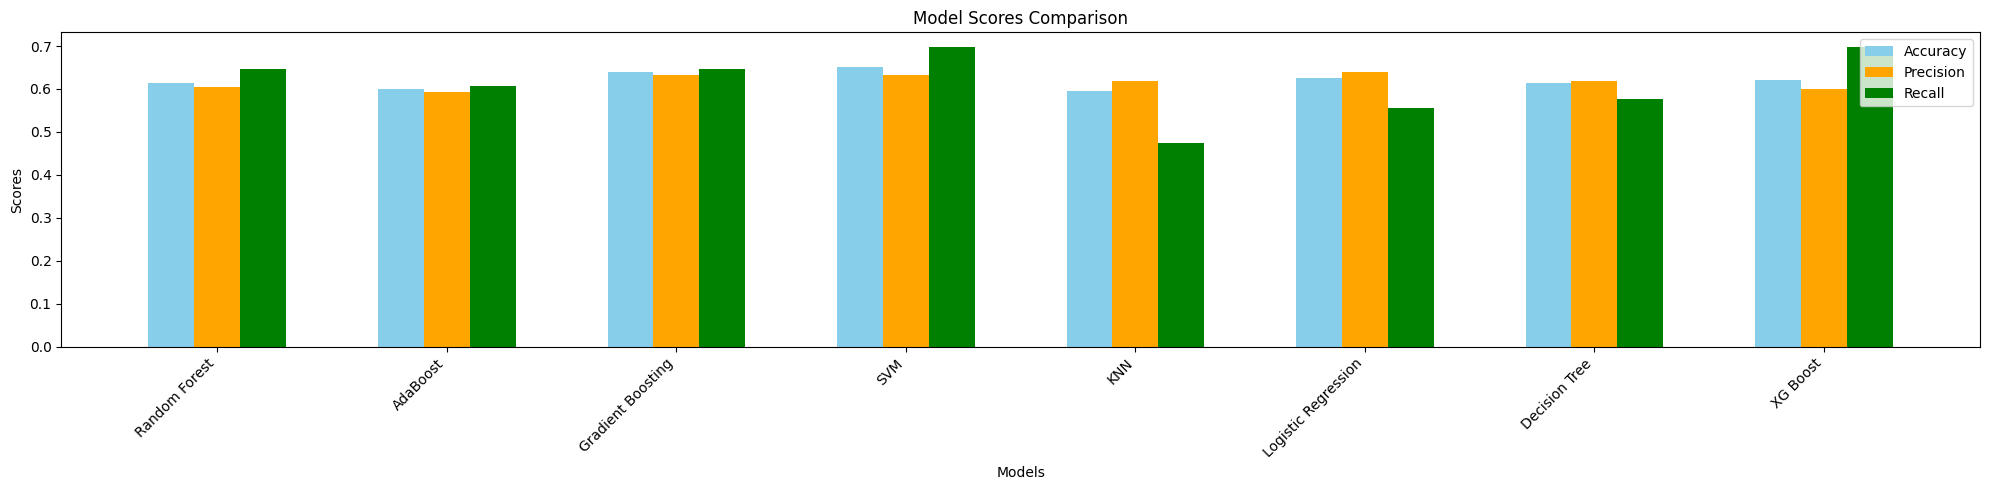

In [448]:
plt.subplots(figsize=(20,5))
# Extract model names and accuracies from all_model_data
model_names = list(all_model_data.keys())
accuracies = [all_model_data[model]["Accuracy"] for model in model_names]
precisions = [all_model_data[model]["Precision"] for model in model_names]
recalls = [all_model_data[model]["Recall"] for model in model_names]

# plt.bar(model_names, accuracies, color='skyblue')
bar_width = 0.2
index = np.arange(len(model_names))

plt.bar(index - bar_width, accuracies, bar_width, label='Accuracy', color='skyblue')
plt.bar(index, precisions, bar_width, label='Precision', color='orange')
plt.bar(index + bar_width, recalls, bar_width, label='Recall', color='green')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Scores Comparison')
plt.xticks(index, model_names, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

* All the models have very low accuracy. Gradient Boosting model is one of the best performing model in here, so next we try to hypertune the parameters of the Gradient boosting model to check whether model performance can be improved or not.

In [449]:
# all feature slected

# for model_name, model in models.items():

#     selected_features = ["Age", "Gender_Male",	"Gender_Female",	"A1C_Result_Missing","A1C_Result_Abnormal","A1C_Result_Normal",	"Gender_Other",  "Num_Lab_Procedures",	"Num_Outpatient_Visits",	"Num_Inpatient_Visits"	,"Num_Emergency_Visits"			,"Num_Medications",	"Num_Diagnoses",	"Admission_Type_Elective",	"Admission_Type_Emergency",	"Admission_Type_Urgent"	,"Diagnosis_Diabetes",	"Diagnosis_Heart Disease",	"Diagnosis_Infection",	"Diagnosis_Injury"]
#     print(f"\n{model_name} model :")        
#     conf_matrix, class_report, accuracy, precision, recall = evaluate_model(X_train, X_test, Y_train, Y_test, model, selected_features)
#     print(accuracy,classification_report)
#     print("___________________________________________________________________________________")

Feature Importance in the Gradient Boosting Model

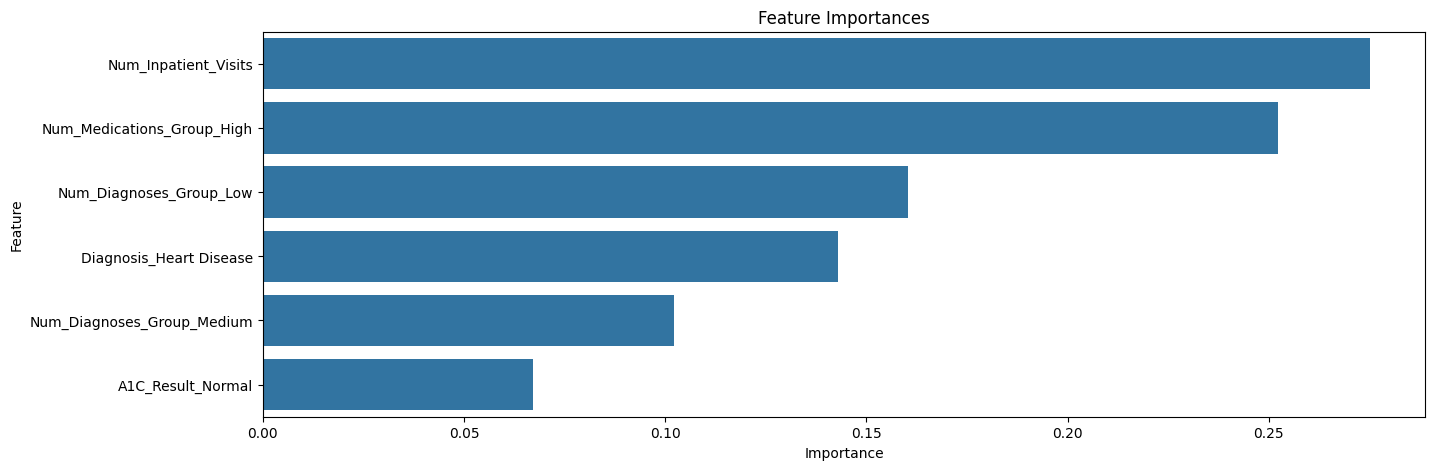

In [450]:
# Get feature importances
importances = all_model_data["Gradient Boosting"]["Model"].feature_importances_
feature_names = all_model_data["Gradient Boosting"]["Features"]

# Create a DataFrame for plotting
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(15, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances')
plt.show()

Hypertuning Gradient Boosting Model

In [451]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
selected_features_gbr = all_model_data["Gradient Boosting"]["Features"]
X_train_gbr = X_train[selected_features_gbr]
X_test_gbr = X_test[selected_features_gbr]

param_grid={
            "n_estimators":[100,200,300],
           "min_samples_split":[30,50,100],
           "learning_rate":[0.1]
           }

gbr=GradientBoostingClassifier(random_state=42)
grid_search=GridSearchCV(estimator=gbr,param_grid=param_grid,cv=5,n_jobs=-1)
grid_search.fit(X_train_gbr,Y_train)
gbr_best_params = grid_search.best_params_

# Training the model with best parameters
final_gbr_model = GradientBoostingClassifier(**gbr_best_params, random_state=42)
final_gbr_model.fit(X_train_gbr, Y_train)

Y_test_pred_gbr = final_gbr_model.predict(X_test_gbr)

classification_rep_gb = classification_report(Y_test, Y_test_pred_gbr, target_names=['No', 'Yes'])
confusion_mat_gb = confusion_matrix(Y_test, Y_test_pred_gbr)
print(f"Hypertuned Gradient Boosting Model Accuracy : {round(accuracy_score(Y_test,Y_test_pred_gbr), 2)}")
print(f"Model Params : {final_gbr_model.get_params()}")
print(f"Classification Report : \n {classification_rep_gb}")

Hypertuned Gradient Boosting Model Accuracy : 0.65
Model Params : {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 30, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Classification Report : 
               precision    recall  f1-score   support

          No       0.65      0.64      0.65       101
         Yes       0.64      0.65      0.64        99

    accuracy                           0.65       200
   macro avg       0.65      0.65      0.64       200
weighted avg       0.65      0.65      0.65       200



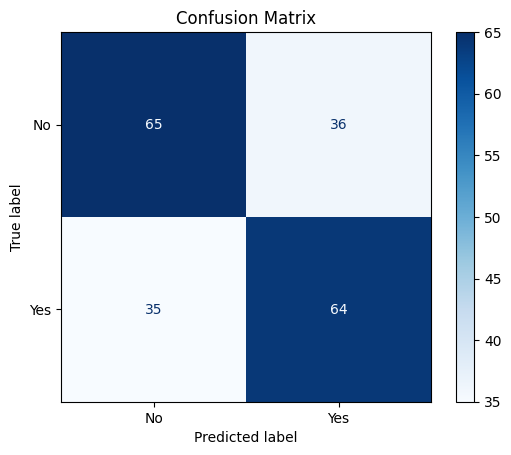

In [452]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat_gb, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

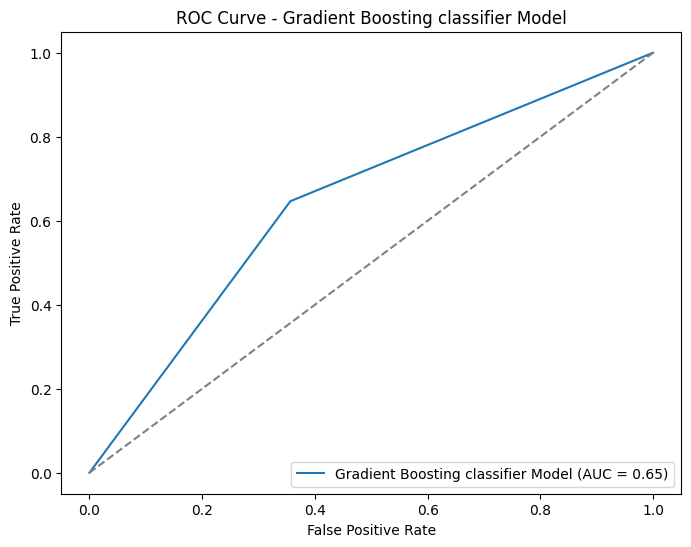

In [453]:
# Calculate ROC curve and AUC score
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(Y_test, Y_test_pred_gbr)
auc_score = roc_auc_score(Y_test, Y_test_pred_gbr)
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Gradient Boosting classifier Model (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - Gradient Boosting classifier Model')
plt.legend(loc='lower right')
plt.show()

In [276]:
# notes on 3 plots,  evalution
# readme

SyntaxError: invalid syntax (933339164.py, line 1)